# Packages and classes def.

In [ ]:
import numpy as np
import os
import cv2
import csv
import random
from imutils import paths
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

import cmath # complex numbers
import gc
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Colab Variable Inspector**

Colab Variable Inspector (`{x}` icon in the left-pane menu) displays all the variables currently defined in your notebook and allows to examine them more closely. The variables are automatically updated, added and removed as you execute in the code.
([Reference](https://colab.research.google.com/github/jupyter-widgets/ipywidgets/blob/7.x/docs/source/examples/Variable%20Inspector.ipynb#scrollTo=GcEmEyWNBD7C))


# Global configuration parameters & model's hyperparameters
Section defining all the global parameters used throughout the code.

- Def. batch size

In [ ]:
batch_size = 32
# https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU

- Model's hyperparameters

In [ ]:
learning_rate = 0.01
comms_round = 100 # numb global epochs/aggregations running during the training
# Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018

loss = 'categorical_crossentropy'
metrics = ['accuracy']
optimizer = keras.optimizers.SGD(learning_rate = learning_rate,
                                 weight_decay = learning_rate/comms_round,
                                 momentum = 0.9)
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
# https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9

- For FL via OTA analysis, noise has complex normal distribution $NC(0, \sigma_n)$ and channel has complex normal distribution $NC(1, \sigma_h)$

In [ ]:
noise_mean = 0.0
chan_mean = 1.0

# File and plotting utilities
Contains all the general-purpose functions used throughout the code.

- Write and read results to `.txt` files

In [ ]:
def write_results_to_txt_file(file_name, inp_list, path):
  """
  Args: file_name: string, name of .txt file (withouth '.txt')
        in_list: input list to be stored in .txt file, with each element written on a separate line
        path: path of txt file
  """
  file = open(path + file_name + '.txt', 'w')
  for item in inp_list:
    file.write(str(float(item))+"\n")
  file.close()

In [ ]:
def read_results_from_txt_file(file_name, path):
  """
  Args: text: string, name of .txt file (withouth '.txt')
        path: path of txt file

  Returns: output list, with each element is a line from .txt file
  """
  with open(path + file_name + '.txt', "r") as file:
    out_lst = [float(line.strip()) for line in file]
  return out_lst

- Plot

In [ ]:
def plot_save_acc_loss_fct(acc, loss, label, title, plot_path, name_fig):
  """
  Plot of accuracy and loss function wrt communication rounds and save .png file in plot_path
  Args: loss and accuracy lists of training model
        label: string; title: string
        plot_path: path of plot; name_fig: string
  """
  plt.figure(figsize=(10,4))
  # plot acc curve
  plt.subplot(1,2,1)
  plt.plot(np.arange(len(acc)), acc, label=label, color='green')
  plt.xlabel('communication rounds')
  plt.ylabel('accuracy')
  plt.title('Accuracy curve')
  plt.grid(True, linestyle='--', alpha=0.3)

  # plot loss curve
  plt.subplot(1,2,2)
  plt.plot(np.arange(len(acc)), loss, label=label, color='green')
  plt.xlabel('communication rounds')
  plt.ylabel('loss')
  plt.title('Loss curve')

  plt.grid(True, linestyle='--', alpha=0.3)
  plt.suptitle(title)

  plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
  plt.tight_layout()

  plt.savefig(os.path.join(plot_path, name_fig + '.png'), dpi=300, bbox_inches='tight')
  plt.show()

  plt.close()
  return

In [ ]:
def lets_plot(lst_to_plot, label=None, title='', ylabel='', color=None,
              lnstl=None, marker=None, lw=None):
  plot_kwargs = {}
  if label:
    plot_kwargs['label'] = label
  if color is not None:
    plot_kwargs['color'] = color
  if lnstl is not None:
    plot_kwargs['linestyle'] = lnstl
  if marker is not None:
    plot_kwargs['marker'] = marker
  if lw is not None:
    plot_kwargs['linewidth'] = lw

  plt.plot(np.arange(len(lst_to_plot)), lst_to_plot, **plot_kwargs)

  plt.title(title)
  plt.xlabel('communication rounds')
  plt.ylabel(ylabel)
  plt.grid(True, linestyle='--', alpha=0.3)

  return

In [ ]:
def save_plot(plot_path, title):
  plt.savefig(os.path.join(plot_path, title + '.png'), dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()
  return

# FL utility functions

In [ ]:
def sum_scaled_weights(scaled_weight_list): # sums all client's scaled weights together
  avg_grad = list()
  # get the average grad accross all client gradients
  # scaled_weight_list is a list of 10 lists of 6 item
  for grad_list_tuple in zip(*scaled_weight_list):
      layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
      avg_grad.append(layer_mean)
  return avg_grad

In [ ]:
@tf.function
def from_real_to_complex(vct_real):
  """
  Args: list of real Tensor.
        Each Tensor is a matrix (n_row, n_col), where n_row is always even numb.
  Returns: list of complex Tensor, with same dimension of input list

  Given the real-valued vector (component of Tensor) of length n_row,
  the output complex vector has lenght n_row/2,
  by mapping pairs pf consecutive elements to the real and imaginary parts of each complex entry.
  The k-th complex component is vect_real[2*k] + i*vect_real[2*k+1].
  If input Tensor is a matrix, this transformation is applied to each column.
  """
  vct_complex = list()
  for comp in vct_real:
    if comp.ndim == 1: # component of in. list is a vector (n_row,)
      new = tf.complex(comp[::2], comp[1::2])

    else: # component of in. list is a matrix (n_row, n_col)
      new = tf.complex(comp[::2, :], comp[1::2, :])

    vct_complex.append(new)
  return vct_complex

In [ ]:
@tf.function
def from_complex_to_real(vct_complex):
    """
    Args: list of complex Tensor.
          Each Tensor is a matrix (n_row, n_col), where n_row is the number of complex rows.
    Returns: list of real Tensor, with same number of columns but twice the number of rows.

    Given a complex-valued vector of length n_row,
    the output real vector has length n_row by splitting the real and imaginary parts
    into consecutive positions in the output tensor.
    If the input Tensor is a matrix, the transformation is applied to each column.
    """
    vct_real = list()
    for comp in vct_complex:
      if comp.ndim == 1: #tf.rank(comp) == 1: # component is a vector
        new = tf.reshape(tf.stack([tf.math.real(comp), tf.math.imag(comp)], axis=1), (-1,))

      else: # component is a matrix (n_row, n_col)
        n_row = tf.shape(comp)[0]
        n_col = tf.shape(comp)[1]

        real_part = tf.math.real(comp)
        imag_part = tf.math.imag(comp)

        stacked = tf.stack([real_part, imag_part], axis=1)
        new = tf.reshape(stacked, (2 * n_row, n_col))

      vct_real.append(new)
    return vct_real

`generate_complex_rand_tensor` function create random Tensor with normally distributed elements. This function is used to generate both the complex random channel vector $h$ and the noise vector $n$.

$h$ is modeled as a complex random variable with mean $1.0$ and standard deviation $\sigma_h$.

$n$ is modeled as a complex random variable with mean $0.0$ and standard deviation $\sigma_n$.

When generating both $h$ and $n$, the real part has mean $1.0$ for $h$ and $0.0$ for $n$, whereas the imaginary component is symmetric around zero, so mean is fixed to $0.0$.

In [ ]:
def generate_complex_rand_tensor(in_list, mean, sd):
    """
    Args: create random Tensor with normally distributed elements with the
          same size of input tensor
          in_list: input list
          mean (float): Mean of the normal distribution.
          sd (float): Standard deviation of the normal distribution.
    Returns: Complex-valued noise list of tensors, with same dim. of intput list
    """
    out_list = in_list.copy()
    for i in range(len(out_list)):
      real_part = tf.random.normal(shape=out_list[i].shape, mean=mean, stddev=sd, dtype=tf.float32)
      imag_part = tf.random.normal(shape=out_list[i].shape, mean=0.0, stddev=sd, dtype=tf.float32) # fixed mean to 0.0
      out_list[i] = tf.complex(real_part, imag_part)
    return out_list

## Training FL function
- `comms_round` = 100
- `chan_check` = True, is the fading case, where the channel vector is a complex random variable; while `chan_check`= False is the no fading case, where the channel is equal to 1 $\forall t$
- `noise_check`= True means that the noise is complex random vector, otherwise is equal to zero

Note that if `training_ideal_test_ota`=True, also `chan_check` and `noise_check` are True.

In [ ]:
def training_FL_OTA(comms_round, lr, loss, metrics, model_type, model, clients_batched, test_batched,
                    chan_check=False, chan_mean=None, chan_sd=None,
                    noise_check=False, noise_mean=None, noise_sd=None, training_ideal_test_ota=False):
  global_count = sum(len(list(clients_batched[client_name])) for client_name in clients_batched) * batch_size

  loss_history = [] # empty lists for plots
  acc_history = []

  for t in range(comms_round):
    global_weights = model.get_weights() # initialized weights of global model
    scaled_local_weight_list = [] # initial list to collect local model weights after scaling

    # randomize client data by keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    for client in client_names: # iterate through training client
      local_model = build_model(shape=784, classes=10, model_type=model_type)
      client_optimizer = keras.optimizers.SGD(learning_rate=lr, weight_decay=lr/comms_round,
                                              momentum=0.9)
      local_model.compile(loss=loss, optimizer=client_optimizer, metrics=metrics)

      # set local model weight to the weight of the global model
      local_model.set_weights(global_weights)
      # fit local model with client's data
      _ = local_model.fit(clients_batched[client], epochs=1, verbose=0)

      # get the total number of data points held by a client
      local_count = tf.data.experimental.cardinality(clients_batched[client]).numpy() * batch_size #n_k

      # transform weights' variables from real to Complex
      complex_loc_weights = from_real_to_complex(local_model.get_weights())

      if not training_ideal_test_ota: # FL case
      # add complex random channel vector
        if chan_check: # FL via OTA case
          chan_vct = generate_complex_rand_tensor(complex_loc_weights, chan_mean, chan_sd)

        else: # ideal FL case
          chan_vct = [tf.complex(1.0, 0.0)] * len(complex_loc_weights)

        scaled_weights = complex_loc_weights.copy()
        for i in range(len(complex_loc_weights)):
          scaled_weights[i] = tf.math.multiply(chan_vct[i], complex_loc_weights[i]) # apply fading to local weights

        scaled_weights = [local_count * i for i in scaled_weights]

      else: # training_ideal_test_ota=True
        scaled_weights = [local_count * w for w in complex_loc_weights]

      scaled_local_weight_list.append(scaled_weights)

      # clear session to free memory after each communication round
      tf.keras.backend.clear_session()
      del local_model # to delete local_model variable
      gc.collect() # garbage collector: to clean memory

    # get average over all local model, sum of scaled weights
    average_weights = [(1/global_count) * x for x in sum_scaled_weights(scaled_local_weight_list)]

    if training_ideal_test_ota: # apply channel to average weights
      chan_vct = generate_complex_rand_tensor(average_weights, chan_mean, chan_sd)
      average_weights = [tf.math.multiply(chan_vct[i], average_weights[i]) for i in range(len(average_weights))]

    # add complex random noise
    if noise_check:
      noise = generate_complex_rand_tensor(average_weights, noise_mean, noise_sd)
      AirComp_average_weights = [average_weights[comp] + noise[comp] for comp in range(len(average_weights))]
    else:
      AirComp_average_weights = average_weights

    # back to Real number
    AirComp_average_weights = from_complex_to_real(AirComp_average_weights)

    # update global model
    model.set_weights(AirComp_average_weights)

    # test gloabl model and print metrics
    catcren = tf.keras.losses.CategoricalCrossentropy()
    for (X_test_batch, y_test_batch) in test_batched:
      logits = model.predict(X_test_batch, verbose=0) # 0: silent, 1: progress bar (default)
      global_loss = catcren(y_test_batch, logits)
      global_acc = sklearn.metrics.accuracy_score(tf.argmax(logits, axis=1), tf.argmax(y_test_batch, axis=1))
      print(f'comm_round: {t} | global_acc: {global_acc:.3%} | global_loss: {global_loss:.3f}')
      acc_history.append(global_acc)
      loss_history.append(global_loss)

  return acc_history, loss_history

# MNIST dataset
 MNIST Modified National Institute of Standards and Technology database is a large database of handwritten digits that is commonly used for training various image processing systems ([here](https://en.wikipedia.org/wiki/MNIST_database)).

 jpeg version of dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/scolianni/mnistasjpg).
 Dataset consists of 42000 digit images with each class stored in separate folder.

- Set dataset and working paths



In [ ]:
# choose dataset and configure global parameter
import_mnist_img = False # boolean: if true import data & transform img data into csv numeric file

mnist_root_path = 'drive/MyDrive/Notebook_Tesi/dataset/MNISTdataset/'

working_set ='trainingSet'
im_csv_path  = mnist_root_path + 'wrk/im_gray_'+ working_set + '.csv'
lab_csv_path = mnist_root_path + 'wrk/im_labels_' + working_set + '.csv'
img_path = mnist_root_path + 'input/' + working_set

out_path = mnist_root_path + 'out/'
plot_path = mnist_root_path + 'out/plots/'

mnist_image_paths = list(paths.list_images(img_path))

- Define number of clients

In [ ]:
mnist_num_clients = 10

# Import and preprocess dataset


In [ ]:
def mnist_img_to_csv(paths, img_csv_path, lab_csv_path, verbose=-1):
  """
  Args: import MNIST image dataset, convert into np array, write images into csv file once
    paths: path of images
    img_csv_path: path of csv file to write images
    lab_csv_path: path of csv file to write labels
    verbose: int
  """
  # import images
  with open(img_csv_path, 'w', newline='') as im_file: # open img file in write mode
    writer = csv.writer(im_file)

    for (i, imgpath) in enumerate(paths):
      im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
      # load the image
      print_pixel = np.array(im_gray)
      image = np.array(im_gray).flatten() # flattening for MLP network architecture
      writer.writerow(image) # write data to csv file

      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        print("[INFO] img processed {}/{}".format(i + 1, len(paths)))
  print(f"CSV file '{img_csv_path}' created successfully")

  # import labels
  with open(lab_csv_path, 'w', newline='') as lab_file:
    writer_lab = csv.writer(lab_file)

    for (i, imgpath) in enumerate(paths):
      label = imgpath.split(os.path.sep)[-2]
      writer_lab.writerow(label)

      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        print("[INFO] label processed {}/{}".format(i + 1, len(paths)))
  print(f"CSV file '{lab_csv_path}' created successfully")
  print("pixel images", print_pixel[0][0].shape)

- Import MNIST data from G.drive

In [ ]:
if import_mnist_img: # if True
  # if file exists, delete it
  if os.path.exists(im_csv_path):
    os.remove(im_csv_path)
  if os.path.exists(lab_csv_path):
    os.remove(lab_csv_path)

  mnist_img_to_csv(mnist_image_paths, im_csv_path, lab_csv_path, verbose=10000)

- Read and preprocessing dataset from csv files

In [ ]:
# create image and label lists from csv files
image_list = list()
label_list = list()

# images
with open(im_csv_path, 'r') as file_im:
  img_reader = csv.reader(file_im)
  for lines in img_reader:
    lines = np.array(lines, dtype='float64')
    image_list.append(lines/255) # scale the image to [0,1]

# labels
with open(lab_csv_path, 'r') as file_lab:
  lab_reader = csv.reader(file_lab)
  for lines in lab_reader:
    label_list.append(lines[0])

In [ ]:
# check len
len(image_list), len(label_list)

(42000, 42000)

In [ ]:
label_list[0]

'9'

# Create train-test split
Use `train_test_split` object from `sklearn` to split the data into train and test, with ratio 9:1, i.e., keep 10% of the whole dataset for testing the trained global model later.  

In [ ]:
lb = sklearn.preprocessing.LabelBinarizer()
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html
# Label binarizer in order to use cross entropy loss in tf
# otherwise, left the label and use sparse categorical entropy
label_list = lb.fit_transform(label_list) # fit label binarizer/transform multi-class labels to binary labels

In [ ]:
label_list[0] # label binarizer

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list,
                                                    test_size=0.1, random_state=42)
# https://builtin.com/data-science/train-test-split
# https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b

In [ ]:
type(X_train), type(y_train), type(X_test), type(y_test)

(list, numpy.ndarray, list, numpy.ndarray)

In [ ]:
y_train.shape, y_test.shape

((37800, 10), (4200, 10))

In [ ]:
len(X_train), len(X_test)

(37800, 4200)

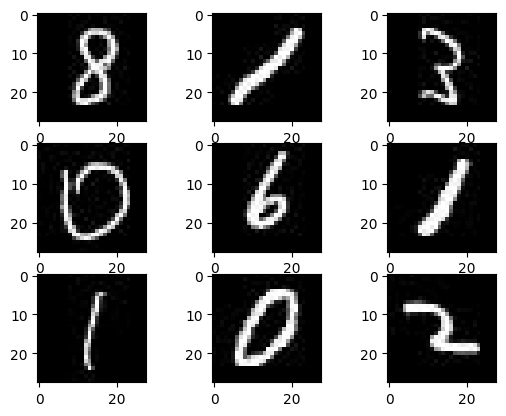

In [ ]:
# https://www.digitalocean.com/community/tutorials/mnist-dataset-in-python
# Plot some MNIST images
from matplotlib import pyplot as plt

for i in range(9):
  plt.subplot(330 + 1 + i)
  image = X_train[i].reshape(28, 28)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.show()

# Create clients & batch data
Share the training set into shards, one per client -federated member, IID.

In [ ]:
def create_clients(image_list, label_list, num_clients):
  """
  Args:
    image_list: list of np arrays of training images
    label_list: list of binarized labels for each image
    num_clients: number of clients to create

  Returns: a dictionary where keys clients names and
           value as data shards-tuple of images and label lists
  """
  # create list of client names with the prefix 'clients'
  client_names = ['{}_{}'.format('client', i+1) for i in range(num_clients)]

  data = list(zip(image_list, label_list))
  random.shuffle(data) #randomize data

  # split/shard img data and place at each client
  size = len(data)//num_clients
  shards = [] #
  for i in range(0, size*num_clients, size):
    shards.append(data[i : i+size])
  # shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

  # check the len
  assert(len(shards) == num_clients)

  return {client_names[i] : shards[i] for i in range(num_clients)}

In [ ]:
clients = create_clients(X_train, y_train, mnist_num_clients)

In [ ]:
clients['client_1'][0][0].shape

(784,)

In [ ]:
for client_name in clients.keys():
  print(f"client name: {client_name} has {len(clients[client_name])} training data")

client name: client_1 has 3780 training data
client name: client_2 has 3780 training data
client name: client_3 has 3780 training data
client name: client_4 has 3780 training data
client name: client_5 has 3780 training data
client name: client_6 has 3780 training data
client name: client_7 has 3780 training data
client name: client_8 has 3780 training data
client name: client_9 has 3780 training data
client name: client_10 has 3780 training data


- Processing and batching clients' and test data


Process each client's data into `tf` dataset and batch them.

In [ ]:
def batch_data(data_shard, batch_size):
  # split data shard as tuple and label lists
  # each client data sets its tuple list data-label
  data, label = zip(*data_shard) # * unpacking operator
  dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))

  return dataset.shuffle(len(label)).batch(batch_size)

In [ ]:
clients_batched = dict()
for (client_name, data) in clients.items():
  clients_batched[client_name] = batch_data(data, batch_size)
  # process and batch training data for each client
# https://eitca.org/artificial-intelligence/eitc-ai-dlpp-deep-learning-with-python-and-pytorch/convolution-neural-network-cnn/training-convnet/what-is-a-common-optimal-batch-size-for-training-a-convolutional-neural-network-cnn/#:~:text=In%20the%20context%20of%20training,pass%20during%20the%20training%20process.

In [ ]:
len(list(clients_batched['client_1']))

119

Process and batch the test set using `tf.data.Dataset` class `.batch()` method.

In [ ]:
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

# Create model

In [ ]:
def build_model(shape, classes, model_type):
  """
  Args:
    shape: int
    classes: int
    model_type: string with model's name

  Returns: keras model
  """
  if model_type == 'mlp':
    model = keras.models.Sequential()
    model.add(layers.Input(shape=(shape,)))

    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(classes, activation='softmax'))
  # elif:
  else: # model 'lenet'
    model = keras.models.Sequential()
    model.add(layers.Input(shape=(shape,)))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(classes, activation='softmax'))

  return model

## MLP model
Create 2 hidden layer Multi Layer Perceptron (MLP) model.

Shape parameter is $28*28*1=784$ and number of classes is $10$.

In [ ]:
mlp_model = build_model(shape=784, classes=10, model_type='mlp')

In [ ]:
len(mlp_model.layers)

3

In [ ]:
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# check parameters
print((784+1)*200) # + 1 = bias
print((200+1)*200)
print((200+1)*10)

157000
40200
2010


In [ ]:
# check batch size = 32
# batch_size = list(clients_batched)[0][0].shape[0]
list(clients_batched['client_1'])[0][0].shape[0]

32

## LeNet 300-100 model
Buil NN model following 300-100 architecture for MNIST dataset.

Input: shape $28*28*1$ and classes $10$.

In [ ]:
lenet_model = build_model(shape=784, classes=10, model_type='lenet')

In [ ]:
len(lenet_model.layers)

3

In [ ]:
lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# check parameters
print((784+1)*300) # + 1 = bias
print((300+1)*100)
print((100+1)*10)

235500
30100
1010


# Federated Learning
Train FedAvg considered as a specific case of FL via over-the-air in which:
- channel vector is equal to a constant unitary: `chan_check=False`
- noise vector is zero: `noise_check=False`
- `training_ideal_test_ota=False`

- MLP model

`model_type='mlp'`

In [ ]:
acc_fl_mlp, loss_fl_mlp = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                          'mlp', mlp_model, clients_batched, test_batched,
                                          chan_check=False, chan_mean=None, chan_sd=None,
                                          noise_check=False, noise_mean=None, noise_sd=None,
                                          training_ideal_test_ota=False)

comm_round: 0 | global_acc: 87.786% | global_loss: 0.427
comm_round: 1 | global_acc: 90.238% | global_loss: 0.333
comm_round: 2 | global_acc: 91.714% | global_loss: 0.292
comm_round: 3 | global_acc: 92.571% | global_loss: 0.262
comm_round: 4 | global_acc: 92.929% | global_loss: 0.243
comm_round: 5 | global_acc: 93.619% | global_loss: 0.222
comm_round: 6 | global_acc: 93.643% | global_loss: 0.211
comm_round: 7 | global_acc: 94.381% | global_loss: 0.196
comm_round: 8 | global_acc: 94.524% | global_loss: 0.189
comm_round: 9 | global_acc: 94.619% | global_loss: 0.178
comm_round: 10 | global_acc: 94.952% | global_loss: 0.174
comm_round: 11 | global_acc: 95.048% | global_loss: 0.165
comm_round: 12 | global_acc: 95.595% | global_loss: 0.160
comm_round: 13 | global_acc: 95.595% | global_loss: 0.155
comm_round: 14 | global_acc: 95.714% | global_loss: 0.154
comm_round: 15 | global_acc: 95.929% | global_loss: 0.147
comm_round: 16 | global_acc: 96.000% | global_loss: 0.144
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_mlp_fl', acc_fl_mlp, out_path)
write_results_to_txt_file('file_out_mnist_loss_mlp_fl', loss_fl_mlp, out_path)

In [ ]:
acc_mlp_fl = read_results_from_txt_file('file_out_mnist_acc_mlp_fl', out_path)
loss_mlp_fl = read_results_from_txt_file('file_out_mnist_loss_mlp_fl', out_path)

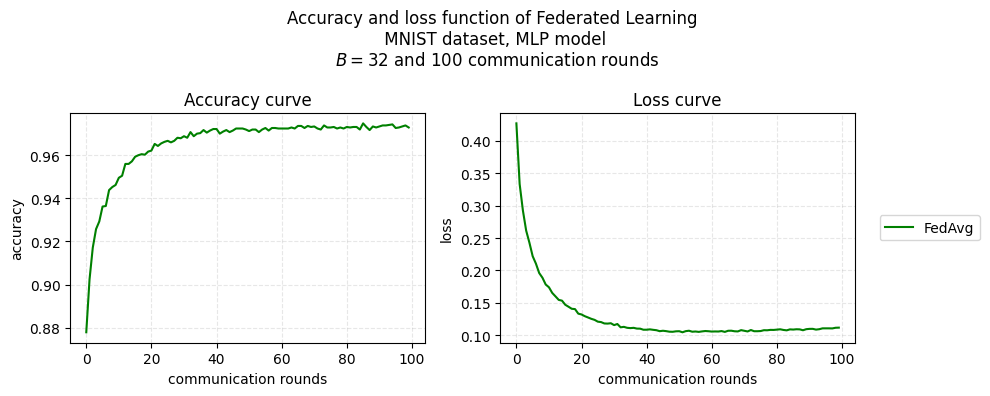

In [ ]:
plot_save_acc_loss_fct(acc_mlp_fl, loss_mlp_fl, 'FedAvg',
                       'Accuracy and loss function of Federated Learning \n MNIST dataset, MLP model \n $B=32$ and $100$ communication rounds',
                       plot_path, 'acc_loss_fl_mlp')

- LeNet 300-100 model

`model_type='lenet'`

In [ ]:
acc_lenet_fl, loss_lenet_fl = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                              'lenet', lenet_model, clients_batched, test_batched,
                                              chan_check=False, chan_mean=None, chan_sd=None,
                                              noise_check=False, noise_mean=None, noise_sd=None,
                                              training_ideal_test_ota=False)

comm_round: 0 | global_acc: 87.905% | global_loss: 0.418
comm_round: 1 | global_acc: 90.429% | global_loss: 0.324
comm_round: 2 | global_acc: 91.571% | global_loss: 0.283
comm_round: 3 | global_acc: 92.762% | global_loss: 0.254
comm_round: 4 | global_acc: 93.333% | global_loss: 0.233
comm_round: 5 | global_acc: 93.595% | global_loss: 0.219
comm_round: 6 | global_acc: 93.810% | global_loss: 0.205
comm_round: 7 | global_acc: 93.976% | global_loss: 0.199
comm_round: 8 | global_acc: 94.786% | global_loss: 0.181
comm_round: 9 | global_acc: 95.024% | global_loss: 0.171
comm_round: 10 | global_acc: 95.071% | global_loss: 0.164
comm_round: 11 | global_acc: 95.333% | global_loss: 0.159
comm_round: 12 | global_acc: 95.524% | global_loss: 0.153
comm_round: 13 | global_acc: 95.667% | global_loss: 0.149
comm_round: 14 | global_acc: 95.952% | global_loss: 0.143
comm_round: 15 | global_acc: 96.000% | global_loss: 0.138
comm_round: 16 | global_acc: 96.214% | global_loss: 0.137
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_lenet_fl', acc_lenet_fl, out_path)
write_results_to_txt_file('file_out_mnist_loss_lenet_fl', loss_lenet_fl, out_path)

In [ ]:
acc_lenet_fl = read_results_from_txt_file('file_out_mnist_acc_lenet_fl', out_path)
loss_lenet_fl = read_results_from_txt_file('file_out_mnist_loss_lenet_fl', out_path)

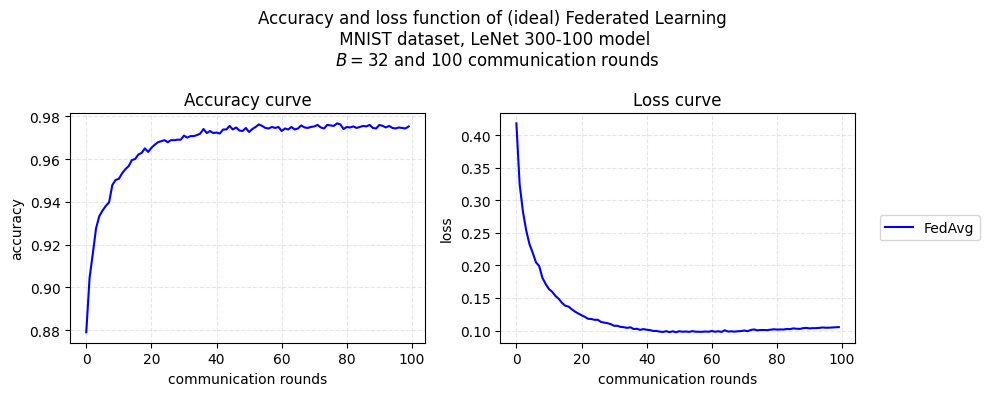

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(acc_lenet_fl)), acc_lenet_fl, label='FedAvg', color='blue')
plt.xlabel('communication rounds')
plt.ylabel('accuracy')
plt.title('Accuracy curve')
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(1,2,2)
plt.plot(np.arange(len(acc_lenet_fl)), loss_lenet_fl, label='FedAvg', color='blue')
plt.xlabel('communication rounds')
plt.ylabel('loss')
plt.title('Loss curve')

plt.grid(True, linestyle='--', alpha=0.3)
plt.suptitle('Accuracy and loss function of (ideal) Federated Learning \n MNIST dataset, LeNet 300-100 model \n $B=32$ and $100$ communication rounds')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

- Accuracy and loss comparison plots

Compare loss and accuracy curve between MLP and LeNet 300-100 models, using same hyper-parameters (batch size $B=32$, communication rounds $C=100$).

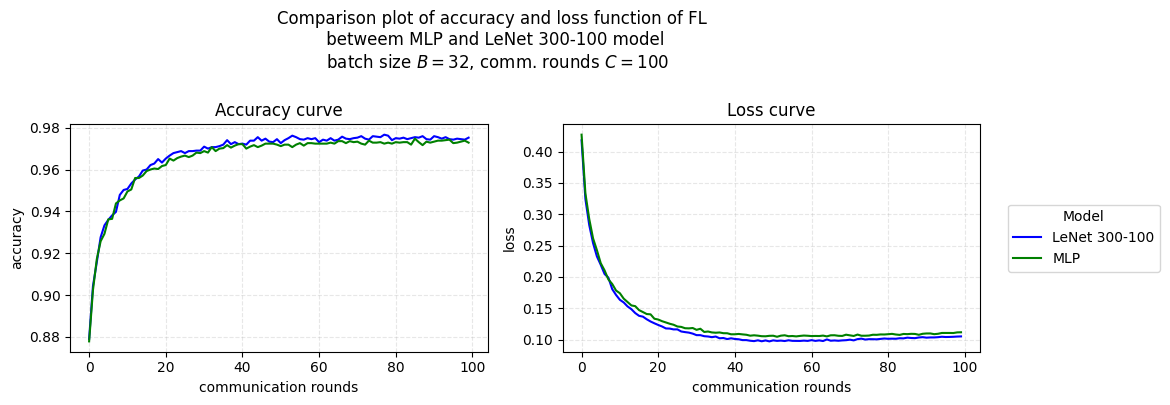

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Comparison plot of accuracy and loss function of FL \n betweem MLP and LeNet 300-100 model \n batch size $B=32$, comm. rounds $C=100$',
             fontsize=12, y=1)
plt.subplot(1,2,1)
lets_plot(acc_lenet_fl, label='', title='', ylabel='', color='b')
lets_plot(acc_mlp_fl, label='', title='Accuracy curve', ylabel='accuracy', color='g')
plt.subplot(1,2,2)
lets_plot(loss_lenet_fl, label='LeNet 300-100', title='', ylabel='', color='b')
lets_plot(loss_mlp_fl, label='MLP', title='Loss curve', ylabel='loss', color='g')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Model')
plt.show()

## Compare FedAvg and SGD
Compare the result of federated average with a standard SGD model trained on the same MNIST dataset.

As model considered is single 3-layer MLP model.

Every hyper-parameter used for FL training is kept, except the batch size which is $320$, rather than $32$. SGD model has the exact same number of training samples per epoch as the global model did per communication round in FL.

In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
SGD_model = build_model(shape=784, classes=10, model_type='mlp')

SGD_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

fit = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

catcren = tf.keras.losses.CategoricalCrossentropy()
for(X_test_batch, y_test_batch) in test_batched:
  logits = SGD_model.predict(X_test_batch, verbose=0)
  global_loss = catcren(y_test_batch, logits)
  global_acc = sklearn.metrics.accuracy_score(tf.argmax(logits, axis=1), tf.argmax(y_test_batch, axis=1))
  print(f'global_acc: {global_acc:.3%} | global_loss: {global_loss:.3f}')

global_acc: 97.024% | global_loss: 0.130


# FL via over-the-air
Let's training the model by FL via over-the-air on MNIST dataset:
- fading case: channel vector is complex random $h\sim NC(1, \sigma_h^2)$
- convert the real weights into complex ones
- add complex random noise $n\sim NC(0, \sigma_n^2 I)$

## No fading case
The channel vector $h$ is constant: $h_i^t =1$ $\forall t$ communication round.

- `chan_check` = False: no fading
- `noise_check` = True: noise is complex random vector with normal distribution, mean $0.0$ and standard deviation
   - `noise_sd`$=0.01$
   - `noise_sd`$=0.02$
   - `noise_sd`$=0.03$
   - `noise_sd`$=0.04$
- `training_ideal_test_ota` = False



1.   `noise_sd`$=0.01$



In [ ]:
ota_acc_001, ota_loss_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                            'mlp', mlp_model, clients_batched, test_batched,
                                            chan_check=False, chan_mean=None, chan_sd=None,
                                            noise_check=True, noise_mean=noise_mean, noise_sd=0.01,
                                            training_ideal_test_ota=False)

comm_round: 0 | global_acc: 87.548% | global_loss: 0.427
comm_round: 1 | global_acc: 90.214% | global_loss: 0.339
comm_round: 2 | global_acc: 91.643% | global_loss: 0.293
comm_round: 3 | global_acc: 92.262% | global_loss: 0.266
comm_round: 4 | global_acc: 93.095% | global_loss: 0.242
comm_round: 5 | global_acc: 93.810% | global_loss: 0.224
comm_round: 6 | global_acc: 94.071% | global_loss: 0.207
comm_round: 7 | global_acc: 94.381% | global_loss: 0.196
comm_round: 8 | global_acc: 94.643% | global_loss: 0.186
comm_round: 9 | global_acc: 94.667% | global_loss: 0.178
comm_round: 10 | global_acc: 95.071% | global_loss: 0.170
comm_round: 11 | global_acc: 95.405% | global_loss: 0.165
comm_round: 12 | global_acc: 95.548% | global_loss: 0.158
comm_round: 13 | global_acc: 95.643% | global_loss: 0.153
comm_round: 14 | global_acc: 95.690% | global_loss: 0.150
comm_round: 15 | global_acc: 96.024% | global_loss: 0.144
comm_round: 16 | global_acc: 95.905% | global_loss: 0.141
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_001', ota_acc_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_001', ota_loss_001, out_path)

2. `noise_sd`$=0.02$

In [ ]:
ota_acc_002, ota_loss_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                            'mlp', mlp_model, clients_batched, test_batched,
                                            chan_check=False, chan_mean=None, chan_sd=None,
                                            noise_check=True, noise_mean=noise_mean, noise_sd=0.02,
                                            training_ideal_test_ota=False)

comm_round: 0 | global_acc: 88.286% | global_loss: 0.414
comm_round: 1 | global_acc: 90.286% | global_loss: 0.330
comm_round: 2 | global_acc: 91.262% | global_loss: 0.291
comm_round: 3 | global_acc: 92.190% | global_loss: 0.266
comm_round: 4 | global_acc: 92.929% | global_loss: 0.242
comm_round: 5 | global_acc: 93.333% | global_loss: 0.225
comm_round: 6 | global_acc: 93.976% | global_loss: 0.209
comm_round: 7 | global_acc: 94.238% | global_loss: 0.197
comm_round: 8 | global_acc: 94.500% | global_loss: 0.186
comm_round: 9 | global_acc: 94.857% | global_loss: 0.180
comm_round: 10 | global_acc: 94.881% | global_loss: 0.172
comm_round: 11 | global_acc: 95.167% | global_loss: 0.167
comm_round: 12 | global_acc: 95.333% | global_loss: 0.159
comm_round: 13 | global_acc: 95.595% | global_loss: 0.157
comm_round: 14 | global_acc: 95.667% | global_loss: 0.150
comm_round: 15 | global_acc: 95.810% | global_loss: 0.144
comm_round: 16 | global_acc: 95.786% | global_loss: 0.143
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_002', ota_acc_002, out_path)
write_results_to_txt_file('file_out_mnist_loss_002', ota_loss_002, out_path)

3. `noise_sd`$=0.03$

In [ ]:
ota_acc_003, ota_loss_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                            'mlp', mlp_model, clients_batched, test_batched,
                                            chan_check=False, chan_mean=None, chan_sd=None,
                                            noise_check=True, noise_mean=noise_mean, noise_sd=0.03,
                                            training_ideal_test_ota=False)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_003', ota_acc_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_003', ota_loss_003, out_path)

4. `noise_sd`$=0.04$

In [ ]:
ota_acc_004, ota_loss_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                            'mlp', mlp_model, clients_batched, test_batched,
                                            chan_check=False, chan_mean=None, chan_sd=None,
                                            noise_check=True, noise_mean=noise_mean, noise_sd=0.04,
                                            training_ideal_test_ota=False)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_004', ota_acc_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_004', ota_loss_004, out_path)

- Comparison plots

Loading accuracy and loss no fading case from `.txt` files, and plotting the results.

In [ ]:
acc_ota_001 = read_results_from_txt_file('file_out_mnist_acc_001', out_path)
loss_ota_001 = read_results_from_txt_file('file_out_mnist_loss_001', out_path)

acc_ota_002 = read_results_from_txt_file('file_out_mnist_acc_002', out_path)
loss_ota_002 = read_results_from_txt_file('file_out_mnist_loss_002', out_path)

acc_ota_003 = read_results_from_txt_file('file_out_mnist_acc_003', out_path)
loss_ota_003 = read_results_from_txt_file('file_out_mnist_loss_003', out_path)

acc_ota_004 = read_results_from_txt_file('file_out_mnist_acc_004', out_path)
loss_ota_004 = read_results_from_txt_file('file_out_mnist_loss_004', out_path)

acc_mlp_fl = read_results_from_txt_file('file_out_mnist_acc_mlp_fl', out_path)
loss_mlp_fl = read_results_from_txt_file('file_out_mnist_loss_mlp_fl', out_path)

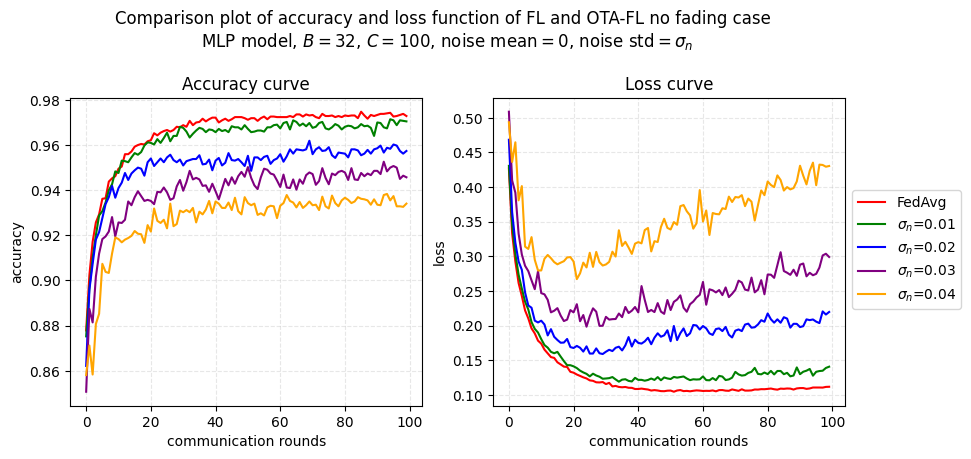

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(acc_ota_001, label='', title='', ylabel='', color='g')
lets_plot(acc_ota_002, label='', title='', ylabel='', color='b')
lets_plot(acc_ota_003, label='', title='', ylabel='', color='purple')
lets_plot(acc_ota_004, label='', title='Accuracy curve', ylabel='accuracy', color='orange')

plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(loss_ota_001, label=r'$\sigma_n$=0.01', title='', ylabel='', color='g')
lets_plot(loss_ota_002, label=r'$\sigma_n$=0.02', title='', ylabel='', color='b')
lets_plot(loss_ota_003, label=r'$\sigma_n$=0.03', title='', ylabel='', color='purple')
lets_plot(loss_ota_004, label=r'$\sigma_n$=0.04', title='Loss curve', ylabel='loss', color='orange')

fig = plt.gcf()
fig.suptitle('Comparison plot of accuracy and loss function of FL and OTA-FL no fading case \n MLP model, $B=32$, $C=100$, noise mean$=0$, noise std$=\\sigma_n$',
             fontsize=12, y=1.1)

fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
save_plot(plot_path, 'acc_loss_no_fading_comparison')

## Fading & no noise
Check the intermediate case where the channel is complex normal distributed $h\sim NC(1,\sigma_h^2)$, but there is no noise, in order to study the impact of channel noise to FedAvg case in terms of standard deviation $\sigma_h^2$.

- `chan_check` = True: fading case, with mean `chan_mean`$=1.0$ and standard deviation:
  - `chan_sd`$=0.1$
  - `chan_sd`$=0.2$
  - `chan_sd`$=0.3$
  - `chan_sd`$=0.4$
- `noise_check` = False
- `training_ideal_test_ota`=False


1. `chan_sd`$=0.1$

In [ ]:
ota_acc_01_000, ota_loss_01_000 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=False)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_000', ota_acc_01_000, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_000', ota_loss_01_000, out_path)

2. `chan_sd`$=0.2$

In [ ]:
ota_acc_02_000, ota_loss_02_000 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=False)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_000', ota_acc_02_000, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_000', ota_loss_02_000, out_path)

3. `chan_sd`$=0.3$

In [ ]:
ota_acc_03_000, ota_loss_03_000 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=False)

comm_round: 0 | global_acc: 86.762% | global_loss: 0.443
comm_round: 1 | global_acc: 89.333% | global_loss: 0.351
comm_round: 2 | global_acc: 90.857% | global_loss: 0.310
comm_round: 3 | global_acc: 91.905% | global_loss: 0.277
comm_round: 4 | global_acc: 92.905% | global_loss: 0.251
comm_round: 5 | global_acc: 92.881% | global_loss: 0.243
comm_round: 6 | global_acc: 93.286% | global_loss: 0.223
comm_round: 7 | global_acc: 94.119% | global_loss: 0.203
comm_round: 8 | global_acc: 94.595% | global_loss: 0.197
comm_round: 9 | global_acc: 94.714% | global_loss: 0.183
comm_round: 10 | global_acc: 94.881% | global_loss: 0.178
comm_round: 11 | global_acc: 94.714% | global_loss: 0.172
comm_round: 12 | global_acc: 94.857% | global_loss: 0.168
comm_round: 13 | global_acc: 95.262% | global_loss: 0.161
comm_round: 14 | global_acc: 95.262% | global_loss: 0.155
comm_round: 15 | global_acc: 95.762% | global_loss: 0.147
comm_round: 16 | global_acc: 95.762% | global_loss: 0.148
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_03_000', ota_acc_03_000, out_path)
write_results_to_txt_file('file_out_mnist_loss_03_000', ota_loss_03_000, out_path)

4. `chan_sd=0.4`

In [ ]:
ota_acc_04_000, ota_loss_04_000 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=False)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_000', ota_acc_04_000, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_000', ota_loss_04_000, out_path)

- Comparison plots

In [ ]:
ota_acc_01_000 = read_results_from_txt_file('file_out_mnist_acc_01_000', out_path)
ota_loss_01_000 = read_results_from_txt_file('file_out_mnist_loss_01_000', out_path)
ota_acc_02_000 = read_results_from_txt_file('file_out_mnist_acc_02_000', out_path)
ota_loss_02_000 = read_results_from_txt_file('file_out_mnist_loss_02_000', out_path)
ota_acc_03_000 = read_results_from_txt_file('file_out_mnist_acc_03_000', out_path)
ota_loss_03_000 = read_results_from_txt_file('file_out_mnist_loss_03_000', out_path)
ota_acc_04_000 = read_results_from_txt_file('file_out_mnist_acc_04_000', out_path)
ota_loss_04_000 = read_results_from_txt_file('file_out_mnist_loss_04_000', out_path)

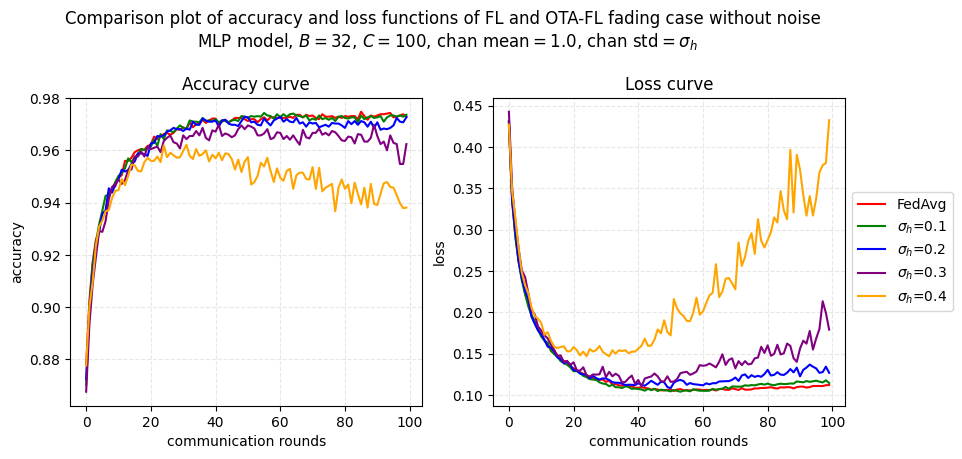

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Comparison plot of accuracy and loss functions of FL and OTA-FL fading case without noise \n MLP model, $B=32$, $C=100$, chan mean$=1.0$, chan std$=\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_000, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_000, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_000, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_000, label='', title='Accuracy curve', ylabel='accuracy', color='orange')

plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_000, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_000, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_000, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_000, label=r'$\sigma_h$=0.4', title='Loss curve', ylabel='loss', color='orange')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_fading_no_noise_comparison')

## FL via OTA w/ fading
The channel is complex normal distributed $h\sim NC(1,\sigma_h^2)$ and the noise has a complex normal distribution $n\sim NC(0, \sigma_n^2)$.

- `chan_check` = True: fading case, with mean `chan_mean`$=1.0$ and standard deviation `chan_sd` $\sigma_h \in\{0.1, 0.2, 0.3,0.4,0.5\}$
- `noise_check` = True: with mean `noise_mean`$=0.0$ and standard deviation `noise_sd` $\sigma_n \in \{0.01,0.02,0.03,0.04,0.05\}$
- `training_ideal_test_ota` = False

### Importing results
Read accuracy and loss results from `.txt` files.

In [ ]:
ota_acc_01_001  = read_results_from_txt_file('file_out_mnist_acc_01_001', out_path)
ota_loss_01_001 = read_results_from_txt_file('file_out_mnist_loss_01_001', out_path)
ota_acc_02_001  = read_results_from_txt_file('file_out_mnist_acc_02_001', out_path)
ota_loss_02_001 = read_results_from_txt_file('file_out_mnist_loss_02_001', out_path)
ota_acc_03_001  = read_results_from_txt_file('file_out_mnist_acc_03_001', out_path)
ota_loss_03_001 = read_results_from_txt_file('file_out_mnist_loss_03_001', out_path)
ota_acc_04_001  = read_results_from_txt_file('file_out_mnist_acc_04_001', out_path)
ota_loss_04_001 = read_results_from_txt_file('file_out_mnist_loss_04_001', out_path)
ota_acc_05_001  = read_results_from_txt_file('file_out_mnist_acc_05_001', out_path)
ota_loss_05_001 = read_results_from_txt_file('file_out_mnist_loss_05_001', out_path)

In [ ]:
ota_acc_01_002  = read_results_from_txt_file('file_out_mnist_acc_01_002', out_path)
ota_loss_01_002 = read_results_from_txt_file('file_out_mnist_loss_01_002', out_path)
ota_acc_02_002  = read_results_from_txt_file('file_out_mnist_acc_02_002', out_path)
ota_loss_02_002 = read_results_from_txt_file('file_out_mnist_loss_02_002', out_path)
ota_acc_03_002  = read_results_from_txt_file('file_out_mnist_acc_03_002', out_path)
ota_loss_03_002 = read_results_from_txt_file('file_out_mnist_loss_03_002', out_path)
ota_acc_04_002  = read_results_from_txt_file('file_out_mnist_acc_04_002', out_path)
ota_loss_04_002 = read_results_from_txt_file('file_out_mnist_loss_04_002', out_path)
ota_acc_05_002  = read_results_from_txt_file('file_out_mnist_acc_05_002', out_path)
ota_loss_05_002 = read_results_from_txt_file('file_out_mnist_loss_05_002', out_path)

In [ ]:
ota_acc_01_003  = read_results_from_txt_file('file_out_mnist_acc_01_003', out_path)
ota_loss_01_003 = read_results_from_txt_file('file_out_mnist_loss_01_003', out_path)
ota_acc_02_003  = read_results_from_txt_file('file_out_mnist_acc_02_003', out_path)
ota_loss_02_003 = read_results_from_txt_file('file_out_mnist_loss_02_003', out_path)
ota_acc_03_003  = read_results_from_txt_file('file_out_mnist_acc_03_003', out_path)
ota_loss_03_003 = read_results_from_txt_file('file_out_mnist_loss_03_003', out_path)
ota_acc_04_003  = read_results_from_txt_file('file_out_mnist_acc_04_003', out_path)
ota_loss_04_003 = read_results_from_txt_file('file_out_mnist_loss_04_003', out_path)
ota_acc_05_003  = read_results_from_txt_file('file_out_mnist_acc_05_003', out_path)
ota_loss_05_003 = read_results_from_txt_file('file_out_mnist_loss_05_003', out_path)

In [ ]:
ota_acc_01_004  = read_results_from_txt_file('file_out_mnist_acc_01_004', out_path)
ota_loss_01_004 = read_results_from_txt_file('file_out_mnist_loss_01_004', out_path)
ota_acc_02_004  = read_results_from_txt_file('file_out_mnist_acc_02_004', out_path)
ota_loss_02_004 = read_results_from_txt_file('file_out_mnist_loss_02_004', out_path)
ota_acc_03_004  = read_results_from_txt_file('file_out_mnist_acc_03_004', out_path)
ota_loss_03_004 = read_results_from_txt_file('file_out_mnist_loss_03_004', out_path)
ota_acc_04_004  = read_results_from_txt_file('file_out_mnist_acc_04_004', out_path)
ota_loss_04_004 = read_results_from_txt_file('file_out_mnist_loss_04_004', out_path)
ota_acc_05_004  = read_results_from_txt_file('file_out_mnist_acc_05_004', out_path)
ota_loss_05_004 = read_results_from_txt_file('file_out_mnist_loss_05_004', out_path)

In [ ]:
ota_acc_01_005  = read_results_from_txt_file('file_out_mnist_acc_01_005', out_path)
ota_loss_01_005 = read_results_from_txt_file('file_out_mnist_loss_01_005', out_path)
ota_acc_02_005  = read_results_from_txt_file('file_out_mnist_acc_02_005', out_path)
ota_loss_02_005 = read_results_from_txt_file('file_out_mnist_loss_02_005', out_path)
ota_acc_03_005  = read_results_from_txt_file('file_out_mnist_acc_03_005', out_path)
ota_loss_03_005 = read_results_from_txt_file('file_out_mnist_loss_03_005', out_path)
ota_acc_04_005  = read_results_from_txt_file('file_out_mnist_acc_04_005', out_path)
ota_loss_04_005 = read_results_from_txt_file('file_out_mnist_loss_04_005', out_path)
ota_acc_05_005  = read_results_from_txt_file('file_out_mnist_acc_05_005', out_path)
ota_loss_05_005 = read_results_from_txt_file('file_out_mnist_loss_05_005', out_path)

In [ ]:
acc_mlp_fl = read_results_from_txt_file('file_out_mnist_acc_mlp_fl', out_path)
loss_mlp_fl = read_results_from_txt_file('file_out_mnist_loss_mlp_fl', out_path)

### Training

-  `chan_sd`$=0.1$ and `noise_sd`$=0.01$

In [ ]:
ota_acc_01_001, ota_loss_01_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01)

comm_round: 0 | global_acc: 88.024% | global_loss: 0.425
comm_round: 1 | global_acc: 90.095% | global_loss: 0.337
comm_round: 2 | global_acc: 91.167% | global_loss: 0.299
comm_round: 3 | global_acc: 92.357% | global_loss: 0.266
comm_round: 4 | global_acc: 93.095% | global_loss: 0.249
comm_round: 5 | global_acc: 93.286% | global_loss: 0.228
comm_round: 6 | global_acc: 93.929% | global_loss: 0.210
comm_round: 7 | global_acc: 94.071% | global_loss: 0.206
comm_round: 8 | global_acc: 94.429% | global_loss: 0.192
comm_round: 9 | global_acc: 94.714% | global_loss: 0.186
comm_round: 10 | global_acc: 94.976% | global_loss: 0.175
comm_round: 11 | global_acc: 95.286% | global_loss: 0.166
comm_round: 12 | global_acc: 95.190% | global_loss: 0.163
comm_round: 13 | global_acc: 95.310% | global_loss: 0.162
comm_round: 14 | global_acc: 95.429% | global_loss: 0.162
comm_round: 15 | global_acc: 95.857% | global_loss: 0.152
comm_round: 16 | global_acc: 95.881% | global_loss: 0.147
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_001', ota_acc_01_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_001', ota_loss_01_001, out_path)

- `chan_sd`$=0.2$ and `noise_sd`$=0.01$

In [ ]:
ota_acc_02_001, ota_loss_02_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_001', ota_acc_02_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_001', ota_loss_02_001, out_path)

- `chan_sd`$=0.3$ and `noise_sd`$=0.01$

In [ ]:
ota_acc_03_001, ota_loss_03_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_03_001', ota_acc_03_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_03_001', ota_loss_03_001, out_path)

- `chan_sd`$=0.4$ and `noise_sd`$=0.01$

In [ ]:
ota_acc_04_001, ota_loss_04_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_001', ota_acc_04_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_001', ota_loss_04_001, out_path)

- `chan_sd`$=0.5$ and `noise_sd`$=0.01$

In [ ]:
ota_acc_05_001, ota_loss_05_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.5,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_05_001', ota_acc_05_001, out_path)
write_results_to_txt_file('file_out_mnist_loss_05_001', ota_loss_05_001, out_path)

- Plot

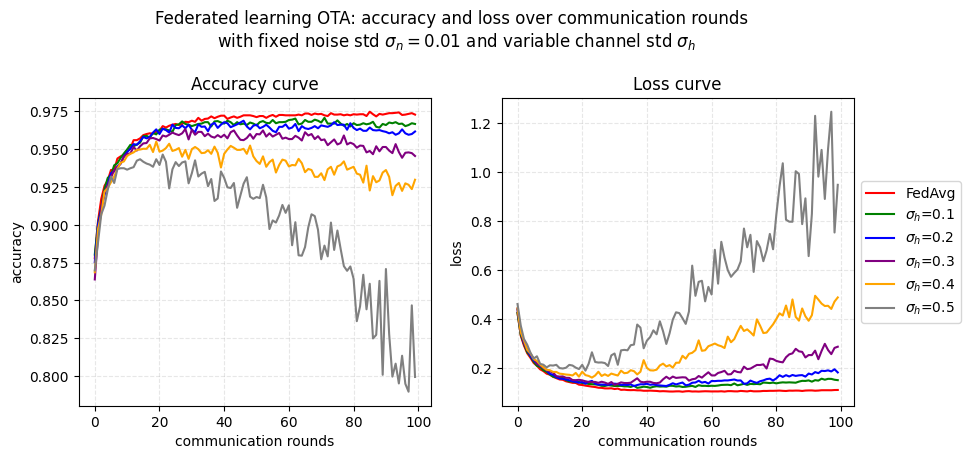

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Federated learning OTA: accuracy and loss over communication rounds \n with fixed noise std $\\sigma_n=0.01$ and variable channel std $\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_001, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_001, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_001, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_001, label='', title='', ylabel='', color='orange')
lets_plot(ota_acc_05_001, label='', title='Accuracy curve', ylabel='accuracy', color='gray')
plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_001, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_001, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_001, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_001, label=r'$\sigma_h$=0.4', title='', ylabel='', color='orange')
lets_plot(ota_loss_05_001, label=r'$\sigma_h$=0.5', title='Loss curve', ylabel='loss', color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_ota_comparison_001')

- `chan_sd`$=0.1$ and `noise_sd`$=0.02$

In [ ]:
ota_acc_01_002, ota_loss_01_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.02)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_002', ota_acc_01_002, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_002', ota_loss_01_002, out_path)

- `chan_mean`$=0.2$ and `noise_sd`$=0.02$

In [ ]:
ota_acc_02_002, ota_loss_02_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                            'mlp', mlp_model, clients_batched, test_batched,
                                                            chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                            noise_check=True, noise_mean=noise_mean, noise_sd=0.02)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_002', ota_acc_02_002, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_002', ota_loss_02_002, out_path)

- `chan_mean`$=0.3$ and `noise_sd`$=0.02$

In [ ]:
ota_acc_03_002, ota_loss_03_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.02)

In [ ]:
write_results_to_txt_file('file_out_acc_mnist_03_002', ota_acc_03_002, out_path)
write_results_to_txt_file('file_out_loss_mnist_03_002', ota_loss_03_002, out_path)

- `chan_mean`$=0.4$ and `noise_sd`$=0.02$

In [ ]:
ota_acc_04_002, ota_loss_04_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.02)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 0 | global_acc: 85.619% | global_loss: 0.478
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 1 | global_acc: 88.929% | global_loss: 0.381
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 2 | global_acc: 89.119% | global_loss: 0.357
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 3 | global_acc: 91.310% | global_loss: 0.291
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 4 | global_acc: 92.095% | global_loss: 0.275
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 5 | global_acc: 91.976% | global_loss: 0.288
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 6 | global_acc: 91.929% | global_loss: 0.263
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 7 | global_acc: 92.714% | global_loss: 0.240
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
comm_round: 8 | global_acc: 91.619% | global_loss: 0.262
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 9 | global_acc: 92.714% | global_loss: 0.243
132/132 ━━━━━━━━━━━━

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_002', ota_acc_04_002, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_002', ota_loss_04_002, out_path)

- `chan_mean`$=0.5$ and `noise_sd`$=0.02$

In [ ]:
ota_acc_05_002, ota_loss_05_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.5,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.02)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_05_002', ota_acc_05_002, out_path)
write_results_to_txt_file('file_out_mnist_loss_05_002', ota_loss_05_002, out_path)

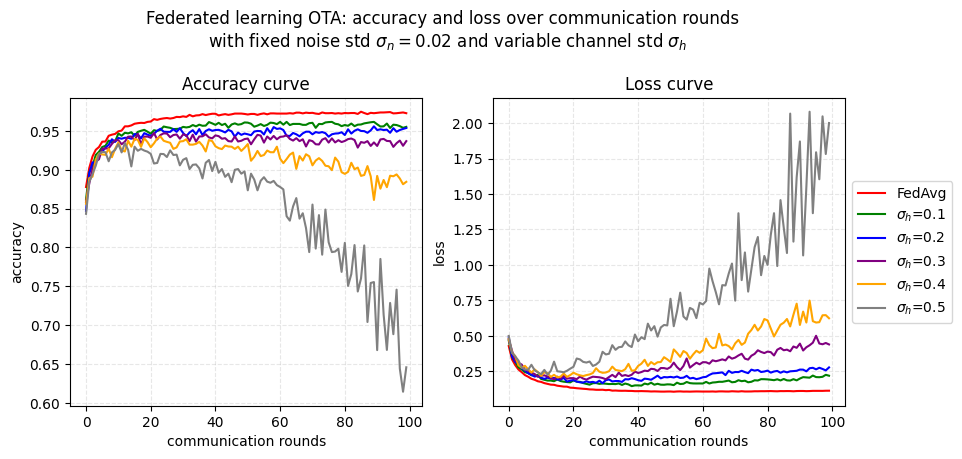

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Federated learning OTA: accuracy and loss over communication rounds \n with fixed noise std $\\sigma_n=0.02$ and variable channel std $\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_002, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_002, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_002, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_002, label='', title='', ylabel='', color='orange')
lets_plot(ota_acc_05_002, label='', title='Accuracy curve', ylabel='accuracy', color='gray')
plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_002, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_002, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_002, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_002, label=r'$\sigma_h$=0.4', title='', ylabel='', color='orange')
lets_plot(ota_loss_05_002, label=r'$\sigma_h$=0.5', title='Loss curve', ylabel='loss', color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_ota_comparison_002')

- `chan_mean`$=0.1$ and `noise_sd`$=0.03$

In [ ]:
ota_acc_01_003, ota_loss_01_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_003', ota_acc_01_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_003', ota_loss_01_003, out_path)

- `chan_mean`$=0.2$ and `noise_sd`$=0.03$

In [ ]:
ota_acc_02_003, ota_loss_02_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_003', ota_acc_02_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_003', ota_loss_02_003, out_path)

- `chan_mean`$=0.3$ and `noise_sd`$=0.03$

In [ ]:
ota_acc_03_003, ota_loss_03_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_03_003', ota_acc_03_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_03_003', ota_loss_03_003, out_path)

- `chan_mean`$=0.4$ and `noise_sd`$=0.03$

In [ ]:
ota_acc_04_003, ota_loss_04_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_003', ota_acc_04_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_003', ota_loss_04_003, out_path)

- `chan_mean`$=0.5$ and `noise_sd`$=0.03$

In [ ]:
ota_acc_05_003, ota_loss_05_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.5,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_05_003', ota_acc_05_003, out_path)
write_results_to_txt_file('file_out_mnist_loss_05_003', ota_loss_05_003, out_path)

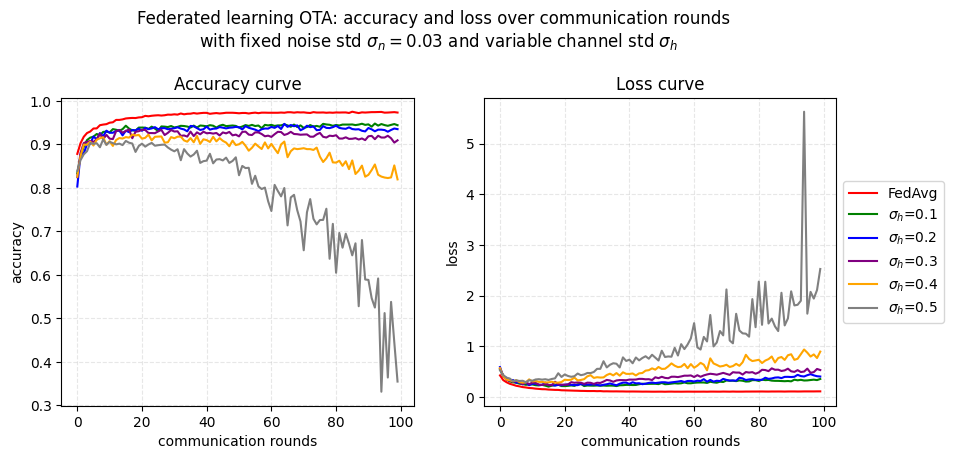

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Federated learning OTA: accuracy and loss over communication rounds \n with fixed noise std $\\sigma_n=0.03$ and variable channel std $\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_003, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_003, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_003, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_003, label='', title='', ylabel='', color='orange')
lets_plot(ota_acc_05_003, label='', title='Accuracy curve', ylabel='accuracy', color='gray')
plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_003, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_003, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_003, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_003, label=r'$\sigma_h$=0.4', title='', ylabel='', color='orange')
lets_plot(ota_loss_05_003, label=r'$\sigma_h$=0.5', title='Loss curve', ylabel='loss', color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_ota_comparison_003')

- `chan_mean`$=0.1$ and `noise_sd`$=0.04$

In [ ]:
ota_acc_01_004, ota_loss_01_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.04)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_004', ota_acc_01_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_004', ota_loss_01_004, out_path)

- `chan_mean`$=0.2$ and `noise_sd`$=0.04$

In [ ]:
ota_acc_02_004, ota_loss_02_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.04)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_004', ota_acc_02_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_004', ota_loss_02_004, out_path)

- `chan_mean`$=0.3$ and `noise_sd`$=0.04$

In [ ]:
ota_acc_03_004, ota_loss_03_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.04)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_03_004', ota_acc_03_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_03_004', ota_loss_03_004, out_path)

- `chan_mean`$=0.4$ and `noise_sd`$=0.04$

In [ ]:
ota_acc_04_004, ota_loss_04_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.04)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_004', ota_acc_04_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_004', ota_loss_04_004, out_path)

- `chan_mean`$=0.5$ and `noise_sd`$=0.04$

In [ ]:
ota_acc_05_004, ota_loss_05_004 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.5,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.04)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_05_004', ota_acc_05_004, out_path)
write_results_to_txt_file('file_out_mnist_loss_05_004', ota_loss_05_004, out_path)

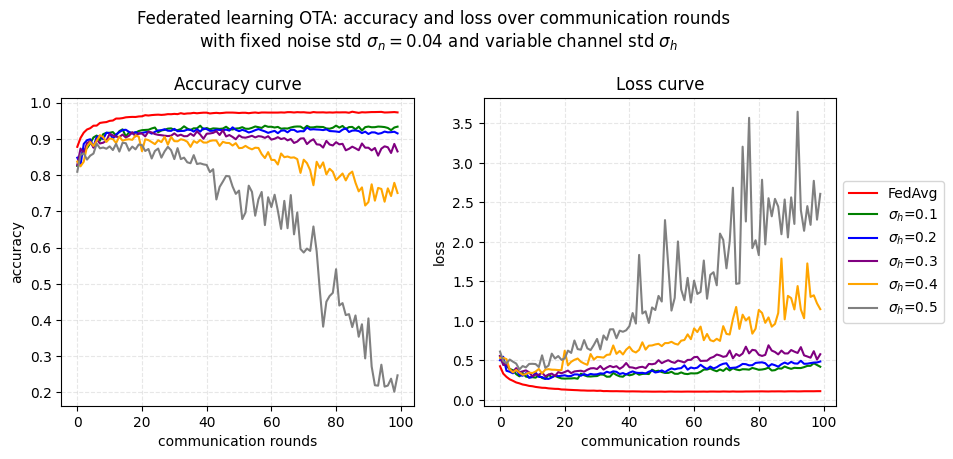

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Federated learning OTA: accuracy and loss over communication rounds \n with fixed noise std $\\sigma_n=0.04$ and variable channel std $\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_004, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_004, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_004, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_004, label='', title='', ylabel='', color='orange')
lets_plot(ota_acc_05_004, label='', title='Accuracy curve', ylabel='accuracy', color='gray')
plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_004, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_004, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_004, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_004, label=r'$\sigma_h$=0.4', title='', ylabel='', color='orange')
lets_plot(ota_loss_05_004, label=r'$\sigma_h$=0.5', title='Loss curve', ylabel='loss', color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_ota_comparison_004')

- `chan_mean`$=0.1$ and `noise_sd`$=0.05$

In [ ]:
ota_acc_01_005, ota_loss_01_005 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.05)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_01_005', ota_acc_01_005, out_path)
write_results_to_txt_file('file_out_mnist_loss_01_005', ota_loss_01_005, out_path)

- `chan_mean`$=0.2$ and `noise_sd`$=0.05$

In [ ]:
ota_acc_02_005, ota_loss_02_005 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.05)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_02_005', ota_acc_02_005, out_path)
write_results_to_txt_file('file_out_mnist_loss_02_005', ota_loss_02_005, out_path)

- `chan_mean`$=0.3$ and `noise_sd`$=0.05$

In [ ]:
ota_acc_03_005, ota_loss_03_005 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.05)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
comm_round: 0 | global_acc: 77.262% | global_loss: 0.690
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 1 | global_acc: 83.786% | global_loss: 0.514
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 2 | global_acc: 86.048% | global_loss: 0.457
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 3 | global_acc: 85.429% | global_loss: 0.478
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 4 | global_acc: 85.071% | global_loss: 0.491
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 5 | global_acc: 87.643% | global_loss: 0.416
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 6 | global_acc: 87.738% | global_loss: 0.434
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 7 | global_acc: 86.929% | global_loss: 0.434
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 8 | global_acc: 89.262% | global_loss: 0.404
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 9 | global_acc: 88.262% | global_loss: 0.423
132/132 ━━━━━━━━━━━━

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_03_005', ota_acc_03_005, out_path)
write_results_to_txt_file('file_out_mnist_loss_03_005', ota_loss_03_005, out_path)

- `chan_mean`$=0.4$ and `noise_sd`$=0.05$

In [ ]:
ota_acc_04_005, ota_loss_04_005 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.4,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.05)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_04_005', ota_acc_04_005, out_path)
write_results_to_txt_file('file_out_mnist_loss_04_005', ota_loss_04_005, out_path)

- `chan_mean`$=0.5$ and `noise_sd`$=0.05$

In [ ]:
ota_acc_05_005, ota_loss_05_005 = training_FL_OTA(comms_round, learning_rate, loss, metrics,
                                                  'mlp', mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.5,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.05)

In [ ]:
write_results_to_txt_file('file_out_mnist_acc_05_005', ota_acc_05_005, out_path)
write_results_to_txt_file('file_out_mnist_loss_05_005', ota_loss_05_005, out_path)

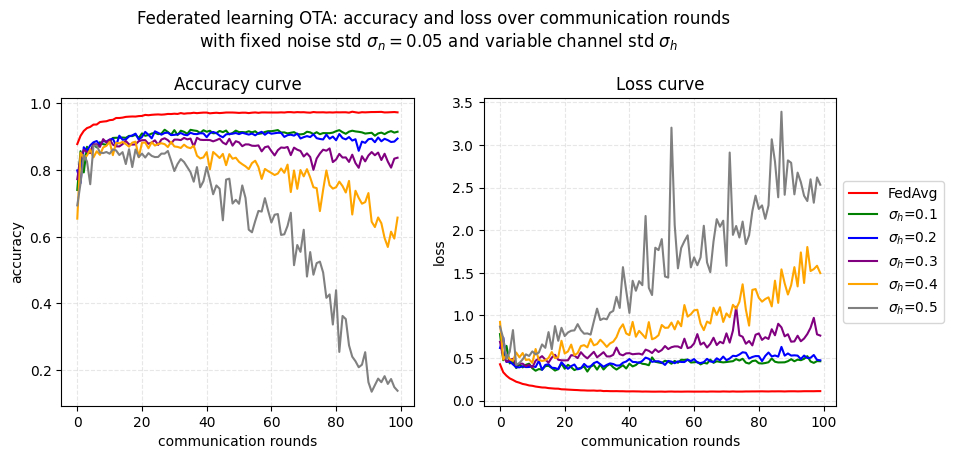

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Federated learning OTA: accuracy and loss over communication rounds \n with fixed noise std $\\sigma_n=0.05$ and variable channel std $\\sigma_h$',
             fontsize=12, y=1.1)
plt.subplot(1,2,1)
lets_plot(acc_mlp_fl, label='', title='', ylabel='', color='r')
lets_plot(ota_acc_01_005, label='', title='', ylabel='', color='g')
lets_plot(ota_acc_02_005, label='', title='', ylabel='', color='b')
lets_plot(ota_acc_03_005, label='', title='', ylabel='', color='purple')
lets_plot(ota_acc_04_005, label='', title='', ylabel='', color='orange')
lets_plot(ota_acc_05_005, label='', title='Accuracy curve', ylabel='accuracy', color='gray')
plt.subplot(1,2,2)
lets_plot(loss_mlp_fl, label='FedAvg', title='', ylabel='', color='r')
lets_plot(ota_loss_01_005, label=r'$\sigma_h$=0.1', title='', ylabel='', color='g')
lets_plot(ota_loss_02_005, label=r'$\sigma_h$=0.2', title='', ylabel='', color='b')
lets_plot(ota_loss_03_005, label=r'$\sigma_h$=0.3', title='', ylabel='', color='purple')
lets_plot(ota_loss_04_005, label=r'$\sigma_h$=0.4', title='', ylabel='', color='orange')
lets_plot(ota_loss_05_005, label=r'$\sigma_h$=0.5', title='Loss curve', ylabel='loss', color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'acc_loss_ota_comparison_005')

### Plot & table


- Table

Resulting table of accuracy wrt the variation of noise and channel standard deviation $\sigma_h$ and $\sigma_n$, respectively.

In [ ]:
rows = ['0.01', '0.02', '0.03', '0.04', '0.05'] # noise_sd
cols = ['0.1', '0.2', '0.3', '0.4', '0.5'] # chan_sd

acc_res = [
    [round(ota_acc_01_001[-1], 3), round(ota_acc_02_001[-1],3),
     round(ota_acc_03_001[-1], 3), round(ota_acc_04_001[-1],3), round(ota_acc_05_001[-1],3)], # noise_sd=0.01
    [round(ota_acc_01_002[-1], 3), round(ota_acc_02_002[-1],3),
     round(ota_acc_03_002[-1], 3), round(ota_acc_04_002[-1],3), round(ota_acc_05_002[-1],3)], # noise_sd=0.02
    [round(ota_acc_01_003[-1], 3), round(ota_acc_02_003[-1],3),
     round(ota_acc_03_003[-1], 3), round(ota_acc_04_003[-1],3), round(ota_acc_05_003[-1],3)], # noise_sd=0.03
    [round(ota_acc_01_004[-1], 3), round(ota_acc_02_004[-1],3),
     round(ota_acc_03_004[-1], 3), round(ota_acc_04_004[-1],3), round(ota_acc_05_004[-1],3)], # noise_sd=0.04
    [round(ota_acc_01_005[-1], 3), round(ota_acc_02_005[-1],3),
     round(ota_acc_03_005[-1], 3), round(ota_acc_04_005[-1],3), round(ota_acc_05_005[-1],3)] # noise_sd=0.05
]

In [ ]:
df = pd.DataFrame(np.array(acc_res), index=[f"σₙ={n}" for n in rows],
                  columns=[f"σₕ={h}" for h in cols])
df

,σₕ=0.1,σₕ=0.2,σₕ=0.3,σₕ=0.4,σₕ=0.5
σₙ=0.01,0.967,0.962,0.945,0.930,0.799
σₙ=0.02,0.955,0.954,0.937,0.885,0.646
σₙ=0.03,0.944,0.935,0.909,0.819,0.355
σₙ=0.04,0.934,0.915,0.865,0.750,0.247
σₙ=0.05,0.915,0.894,0.837,0.657,0.138


- Resulting plot

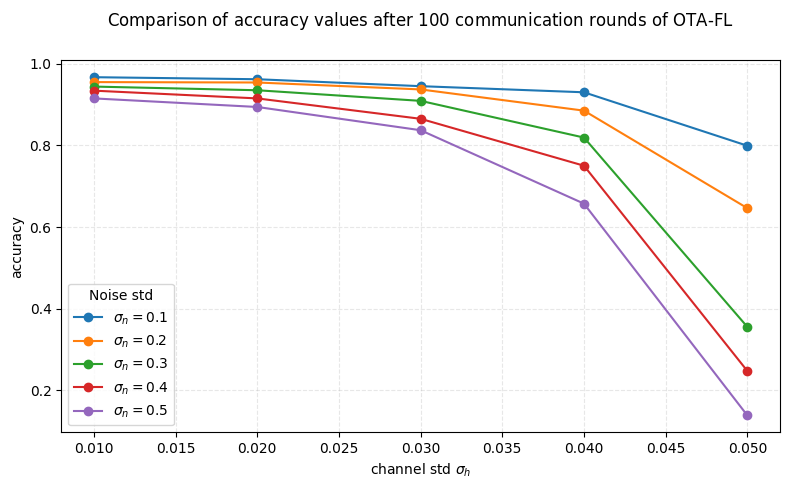

In [ ]:
noise_sd = [0.1, 0.2, 0.3, 0.4, 0.5]
chan_sd = [0.01, 0.02, 0.03, 0.04, 0.05]

plt.figure(figsize=(8, 5))
for i, sn in enumerate(noise_sd):
    plt.plot(chan_sd, acc_res[i], marker='o', label=fr'$\sigma_n = {sn:.1f}$')

plt.xlabel(r'channel std $\sigma_h$')
plt.ylabel('accuracy')
plt.title('Comparison of accuracy values after $100$ communication rounds of OTA-FL', y=1.07)
plt.legend(title='Noise std')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

save_plot(plot_path, 'final_ota_acc_comparison')

## FL with ideal training and test over-the-air
This section analyse the ideal case evaluated over-the-air, where the model performs a perfect aggregation of local updates without any channel-induced distortion. Then, fading and noise are applied to the aggregated model to simulate transmission through a wireless channel.

- `chan_check` = True: `chan_mean`$=0.1$
- `noise_check` = True: `noise_sd`$=0.01$
- `training_ideal_test_ota` = True

In [ ]:
res_acc_01_001, res_loss_01_001 = training_FL_OTA(comms_round, learning_rate, loss, metrics, 'mlp',
                                                  mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.1,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.01,
                                                  training_ideal_test_ota=True)

In [ ]:
write_results_to_txt_file('file_out_mnist_ideal_test_acc_01_001', res_acc_01_001, out_path)
write_results_to_txt_file('file_out_mnist_ideal_test_loss_01_001', res_acc_01_001, out_path)

- `chan_sd`$=0.2$ and `noise_sd`$=0.02$



In [ ]:
res_acc_02_002, res_loss_02_002 = training_FL_OTA(comms_round, learning_rate, loss, metrics, 'mlp',
                                                  mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.2,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.02,
                                                  training_ideal_test_ota=True)

comm_round: 0 | global_acc: 86.381% | global_loss: 0.468
comm_round: 1 | global_acc: 88.881% | global_loss: 0.386
comm_round: 2 | global_acc: 89.000% | global_loss: 0.362
comm_round: 3 | global_acc: 90.595% | global_loss: 0.331
comm_round: 4 | global_acc: 89.905% | global_loss: 0.321
comm_round: 5 | global_acc: 91.381% | global_loss: 0.283
comm_round: 6 | global_acc: 90.500% | global_loss: 0.325
comm_round: 7 | global_acc: 91.762% | global_loss: 0.292
comm_round: 8 | global_acc: 91.214% | global_loss: 0.297
comm_round: 9 | global_acc: 92.381% | global_loss: 0.269
comm_round: 10 | global_acc: 90.905% | global_loss: 0.311
comm_round: 11 | global_acc: 90.643% | global_loss: 0.316
comm_round: 12 | global_acc: 90.571% | global_loss: 0.326
comm_round: 13 | global_acc: 89.619% | global_loss: 0.368
comm_round: 14 | global_acc: 90.762% | global_loss: 0.328
comm_round: 15 | global_acc: 90.952% | global_loss: 0.316
comm_round: 16 | global_acc: 90.381% | global_loss: 0.355
comm_round: 17 | global_

In [ ]:
write_results_to_txt_file('file_out_mnist_ideal_test_acc_02_002', res_acc_02_002, out_path)
write_results_to_txt_file('file_out_mnist_ideal_test_loss_02_002', res_acc_02_002, out_path)

- `chan_mean`$=0.3$ and `noise_sd`$=0.03$

In [ ]:
res_acc_03_003, res_loss_03_003 = training_FL_OTA(comms_round, learning_rate, loss, metrics, 'mlp',
                                                  mlp_model, clients_batched, test_batched,
                                                  chan_check=True, chan_mean=chan_mean, chan_sd=0.3,
                                                  noise_check=True, noise_mean=noise_mean, noise_sd=0.03,
                                                  training_ideal_test_ota=True)

In [ ]:
write_results_to_txt_file('file_out_mnist_ideal_test_acc_03_003', res_acc_03_003, out_path)
write_results_to_txt_file('file_out_mnist_ideal_test_loss_03_003', res_acc_03_003, out_path)

## Comparison plot

In [ ]:
acc_mlp_fl = read_results_from_txt_file('file_out_mnist_acc_mlp_fl', out_path)

ota_acc_01_001  = read_results_from_txt_file('file_out_mnist_acc_01_001', out_path)
ota_acc_02_002  = read_results_from_txt_file('file_out_mnist_acc_02_002', out_path)
ota_acc_03_003  = read_results_from_txt_file('file_out_mnist_acc_03_003', out_path)

res_acc_01_001 = read_results_from_txt_file('file_out_mnist_ideal_test_acc_01_001', out_path)
res_acc_02_002 = read_results_from_txt_file('file_out_mnist_ideal_test_acc_02_002', out_path)
res_acc_03_003 = read_results_from_txt_file('file_out_mnist_ideal_test_acc_03_003', out_path)

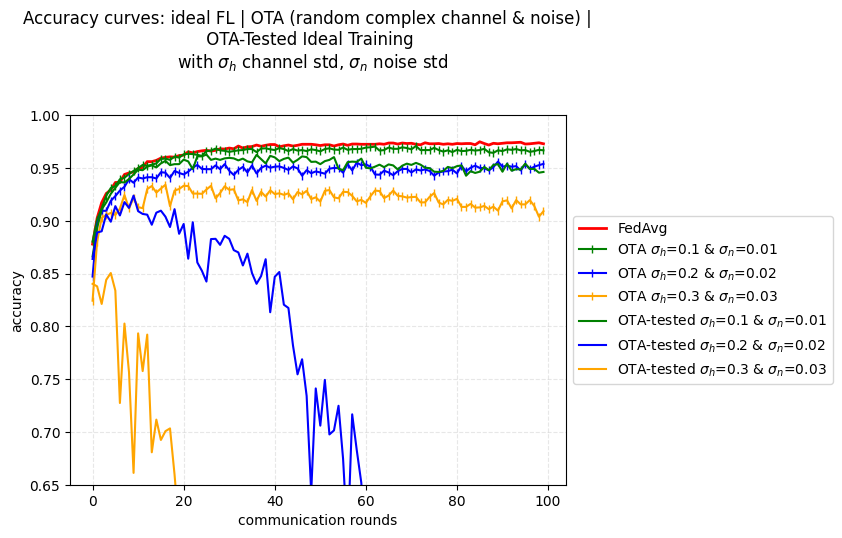

In [ ]:
plt.suptitle('Accuracy curves: ideal FL | OTA (random complex channel & noise) | \n OTA-Tested Ideal Training \n with $\sigma_h$ channel std, $\sigma_n$ noise std',
             fontsize=12, y=1.1)
lets_plot(acc_mlp_fl, label='FedAvg', title='', ylabel='', color='r', lw=2)

lets_plot(ota_acc_01_001, label='OTA $\sigma_h$=0.1 & $\sigma_n$=0.01', title='',
          ylabel='', color='g', marker='|')
lets_plot(ota_acc_02_002, label='OTA $\sigma_h$=0.2 & $\sigma_n$=0.02', title='',
          ylabel='', color='b', marker='|')
lets_plot(ota_acc_03_003, label='OTA $\sigma_h$=0.3 & $\sigma_n$=0.03', title='',
          ylabel='', color='orange', marker='|')

lets_plot(res_acc_01_001, label='OTA-tested $\sigma_h$=0.1 & $\sigma_n$=0.01', title='',
          ylabel='', color='g', lnstl='-')
lets_plot(res_acc_02_002, label='OTA-tested $\sigma_h$=0.2 & $\sigma_n$=0.02', title='',
          ylabel='', color='b', lnstl='-')
lets_plot(res_acc_03_003, label='OTA-tested $\sigma_h$=0.3 & $\sigma_n$=0.03', title='',
          ylabel='accuracy', color='orange', lnstl='-')
plt.ylim(0.65, 1.0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_plot(plot_path, 'final_comparison')
plt.show()

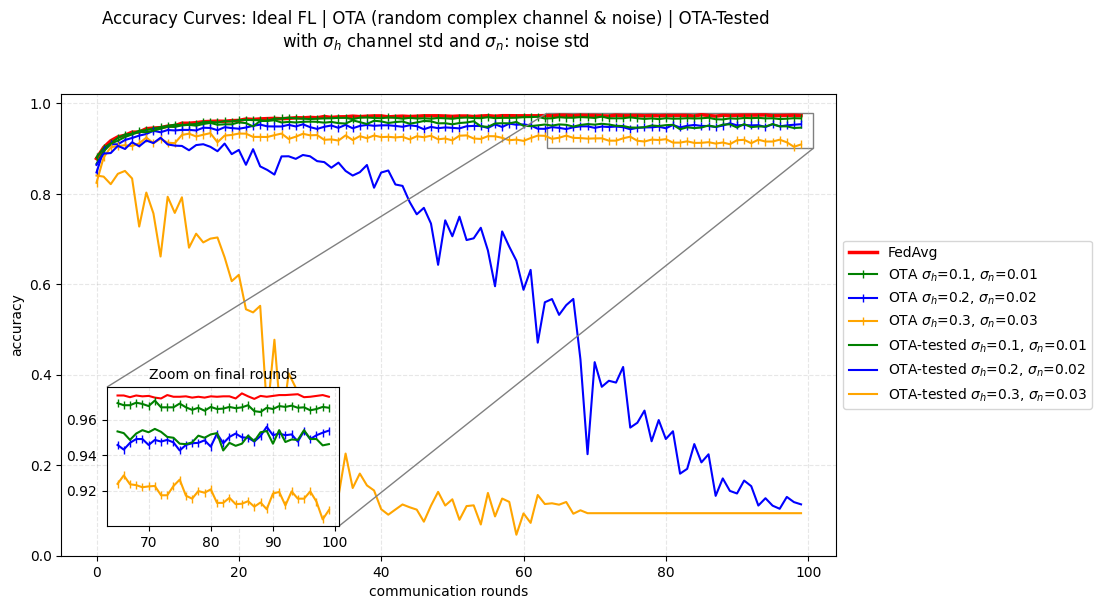

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def lets_plot_(lst_to_plot, label, color, lnstl='-', linewidth=1.5, ax=None, marker=None):
    x = np.arange(len(lst_to_plot))
    if ax is None:
        ax = plt.gca()
    ax.plot(x, lst_to_plot, label=label, color=color, linestyle=lnstl, linewidth=linewidth, marker=marker)

fig, ax_main = plt.subplots(figsize=(10, 6))

fig.suptitle('Accuracy Curves: Ideal FL | OTA (random complex channel & noise) | OTA-Tested\n'
             'with $\\sigma_h$ channel std and $\\sigma_n$: noise std', fontsize=12, y=1.02)

lets_plot_(acc_mlp_fl, 'FedAvg', 'red', linewidth=2.5, ax=ax_main)
lets_plot_(ota_acc_01_001, 'OTA $\\sigma_h$=0.1, $\\sigma_n$=0.01', 'green', ax=ax_main, marker='|')
lets_plot_(ota_acc_02_002, 'OTA $\\sigma_h$=0.2, $\\sigma_n$=0.02', 'blue', ax=ax_main, marker='|')
lets_plot_(ota_acc_03_003, 'OTA $\\sigma_h$=0.3, $\\sigma_n$=0.03', 'orange', ax=ax_main, marker='|')
lets_plot_(res_acc_01_001, 'OTA-tested $\\sigma_h$=0.1, $\\sigma_n$=0.01', 'green', ax=ax_main)
lets_plot_(res_acc_02_002, 'OTA-tested $\\sigma_h$=0.2, $\\sigma_n$=0.02', 'blue', ax=ax_main)
lets_plot_(res_acc_03_003, 'OTA-tested $\\sigma_h$=0.3, $\\sigma_n$=0.03', 'orange', ax=ax_main)

ax_main.set_xlabel('communication rounds')
ax_main.set_ylabel('accuracy')
ax_main.grid(True, linestyle='--', alpha=0.3)
ax_main.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# zoom on last comms rounds
zoom_range = 35
total_len = len(acc_mlp_fl)
zoom_start = total_len - zoom_range
x_zoom = np.arange(zoom_start, total_len)

ax_inset = inset_axes(ax_main, width="30%", height="30%", loc='lower left',
                      bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax_main.transAxes)

# zoom the first five curves
x_zoom = np.arange(zoom_start, total_len)
ax_inset.plot(x_zoom, acc_mlp_fl[zoom_start:], label='FedAvg', color='red')
ax_inset.plot(x_zoom, ota_acc_01_001[zoom_start:], label='OTA 0.1/0.01', color='green', marker='|')
ax_inset.plot(x_zoom, ota_acc_02_002[zoom_start:], label='OTA 0.2/0.02', color='blue', marker='|')
ax_inset.plot(x_zoom, ota_acc_03_003[zoom_start:], label='OTA 0.3/0.03', color='orange', marker='|')
ax_inset.plot(x_zoom, res_acc_01_001[zoom_start:], label='OTA-tested 0.1/0.01', color='green')

ax_inset.set_title("Zoom on final rounds", fontsize=10)
ax_inset.grid(True, linestyle='--', alpha=0.3)
mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

# Experiments and testing

## Federated Learning

First implementation of ideal federated learning model, tested on MNIST dataset.

Data being used is horizontally partitioned

$f(w)=\sum_{k=1}^K \frac{n_k}{n}F_k(w)$ where $F_k(w)=\frac 1{n_k}\sum_{i \in P_k} f_i(w)$

On the right hand side, we are estimating the weight parameters for each client based on the loss values recorded across every data point they trained with. On the left, we scaled each of those parameters and sum them all component-wise.

In [ ]:
def scaling_factor(clients_train_data, client_name, global_count):
  # client data batched
  client_data = clients_train_data[client_name]

  # get the total number of data points held by a client
  local_count = tf.data.experimental.cardinality(clients_train_data[client_name]).numpy()*batch_size # n_k
  scaling_factor = local_count/global_count

  return  scaling_factor # n_k/n

def scale_weights(weight, scal_fact):
  fin_weight = list()
  for i in range(len(weight)):
      fin_weight.append(scal_fact * weight[i])
  return fin_weight

In [ ]:
def sum_scaled_weights(scaled_weight_list): # sums all client's scaled weights together
  avg_grad = list()
  # get the average grad accross all client gradients
  # scaled_weight_list is a list of 10 lists of 6 item
  for grad_list_tuple in zip(*scaled_weight_list):
      layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
      avg_grad.append(layer_mean)
  return avg_grad

In [ ]:
def training_model(comms_round, lr, loss, metrics, model_type, model, client_batched, test_batched):
  global_count = sum(len(list(clients_batched[client_name])) for client_name in list(clients_batched.keys()))*batch_size # n

  loss_history = [] # empty lists for plots
  acc_history = []

  for i in range(comms_round):
    # initialized weights of global model
    global_weights = model.get_weights()

    # initial list to collect local model weights after scaling
    scaled_local_weight_list = list()

    # randomize client data by keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    for client in client_names: # iterate through client training
      local_model = build_model(shape=784, classes=10, model_type=model_type)
      client_optimizer = keras.optimizers.SGD(learning_rate = lr,
                                  weight_decay = lr/comms_round,
                                  momentum = 0.9)

      local_model.compile(loss=loss, optimizer=client_optimizer, metrics=metrics)

      # set local model weight to the weight of the global model
      local_model.set_weights(global_weights)

      # fit local model with client's data
      local_model.fit(clients_batched[client], epochs=1, verbose=0)

      # scale the model weights and add to list
      scal_factor = scaling_factor(clients_batched, client, global_count)
      scaled_weights = scale_weights(local_model.get_weights(), scal_factor) ####

      scaled_local_weight_list.append(scaled_weights)

      # clear session to free memory after each communication round
      tf.keras.backend.clear_session()
      # https://keras.io/2.15/api/utils/backend_utils/

    # get average over all local model, sum of scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    # update global model
    model.set_weights(average_weights)

    # test global model and print metrics
    catcren = tf.keras.losses.CategoricalCrossentropy()
    for(X_test_batch, y_test_batch) in test_batched:
      logits = model.predict(X_test_batch)
      global_loss = catcren(y_test_batch, logits)
      global_acc = sklearn.metrics.accuracy_score(tf.argmax(logits, axis=1), tf.argmax(y_test_batch, axis=1))
      print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(i, global_acc, global_loss))
      acc_history.append(global_acc)
      loss_history.append(global_loss)

  return acc_history, loss_history

### MNIST: training MLP model
Training MLP model on MNIST dataset.

In [ ]:
acc_mlp, loss_mlp = training_model(comms_round, learning_rate, loss, metrics, 'mlp', mlp_model, clients_batched, test_batched)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
comm_round: 0 | global_acc: 87.357% | global_loss: 0.4277394115924835
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 1 | global_acc: 89.905% | global_loss: 0.33784592151641846
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 2 | global_acc: 91.286% | global_loss: 0.29606392979621887
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 3 | global_acc: 92.357% | global_loss: 0.2614976167678833
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
comm_round: 4 | global_acc: 92.952% | global_loss: 0.2441953867673874
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
comm_round: 5 | global_acc: 93.619% | global_loss: 0.22266657650470734
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 6 | global_acc: 94.048% | global_loss: 0.20701226592063904
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 7 | global_acc: 94.381% | global_loss: 0.1956169456243515
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 8 | global_acc: 94.524% | global_loss: 0.18559263646602

Save loss and accuracy into `.txt` file.

In [ ]:
write_results_to_txt_file('file_out_acc_mlp', acc_mlp, out_path)
write_results_to_txt_file('file_out_loss_mlp', loss_mlp, out_path)

Read from `.txt` file accuracy and loss lists to plot.

In [ ]:
acc_mlp_plot = read_results_from_txt_file('file_out_acc_mlp', out_path)
loss_mlp_plot = read_results_from_txt_file('file_out_loss_mlp', out_path)

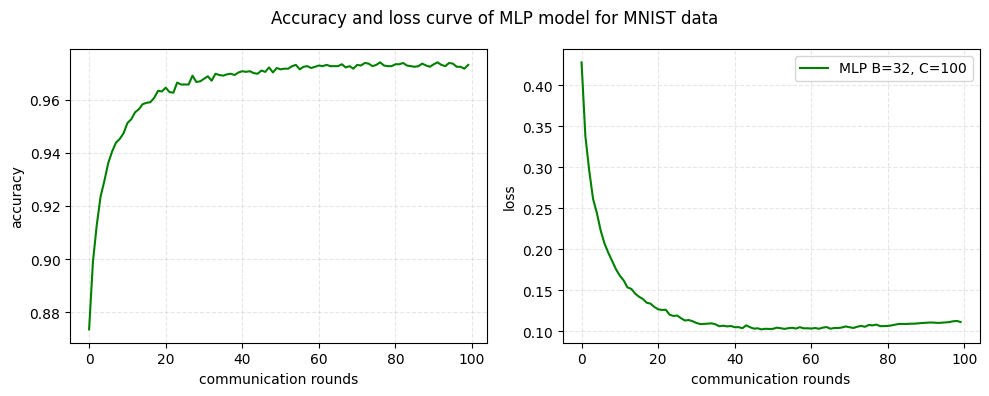

In [ ]:
plot_acc_loss_fct(acc_mlp_plot, loss_mlp_plot, 'MLP B=32, C=100',
                  'Accuracy and loss curve of MLP model for MNIST data')

- Comparison plots

Compare the FL results of OG code by `training_model` function and `training_model_FL_AirComp` function no fading (constant channel vector to $1$) and no noise ($=0$).

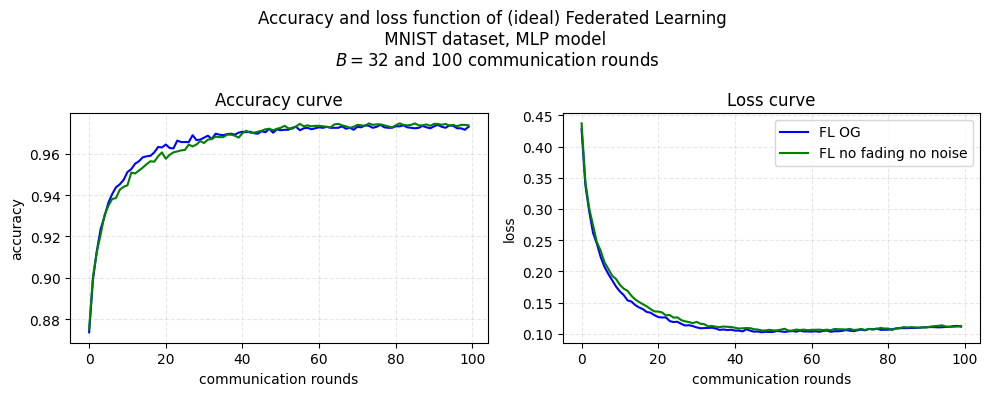

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Accuracy and loss function of (ideal) Federated Learning \n MNIST dataset, MLP model \n $B=32$ and $100$ communication rounds', fontsize=12)
plt.subplot(1,2,1)
lets_plot(acc_mlp_plot, label='', title='', ylabel='', color='b')
lets_plot(acc_fl_plot, label='', title='Accuracy curve', ylabel='accuracy', color='g')
plt.subplot(1,2,2)
lets_plot(loss_mlp_plot, label='FL OG', title='', ylabel='', color='b')
lets_plot(loss_fl_plot, label='FL no fading no noise', title='Loss curve', ylabel='loss', color='g')

### MNIST: training LeNet model
Training LeNet 300-100 model on MNIST dataset.

Hyperparameters (learning rate, communications round, loss, optimizer, accuracy) for LeNet are same of previous 3-layer MLP model.

In [ ]:
lenet_acc, lenet_loss = training_model(comms_round, learning_rate, loss, metrics, 'lenet', lenet_model, clients_batched, test_batched)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 0 | global_acc: 87.952% | global_loss: 0.41191041469573975
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 1 | global_acc: 90.310% | global_loss: 0.32655444741249084
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 2 | global_acc: 91.976% | global_loss: 0.2836257815361023
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 3 | global_acc: 92.595% | global_loss: 0.25495293736457825
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 4 | global_acc: 93.310% | global_loss: 0.2332579642534256
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 5 | global_acc: 93.857% | global_loss: 0.215849831700325
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 6 | global_acc: 94.357% | global_loss: 0.19976793229579926
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 7 | global_acc: 94.619% | global_loss: 0.1887851357460022
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 8 | global_acc: 95.048% | global_loss: 0.178054720163345

In [ ]:
write_results_to_txt_file('file_out_acc_lenet', lenet_acc, out_path)
write_results_to_txt_file('file_out_loss_lenet', lenet_loss, out_path)

In [ ]:
acc_lenet_plot = read_results_from_txt_file('file_out_acc_lenet', out_path)
loss_lenet_plot = read_results_from_txt_file('file_out_loss_lenet', out_path)

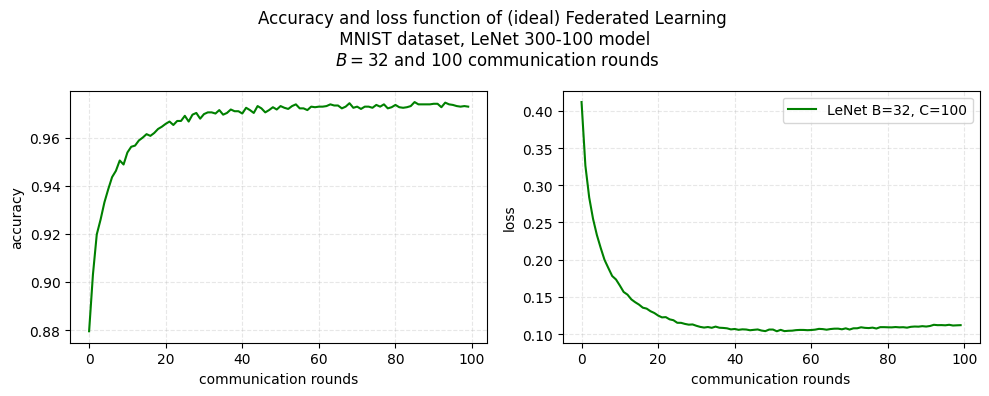

In [ ]:
plot_acc_loss_fct(acc_lenet_plot, loss_lenet_plot, 'LeNet B=32, C=100',
                  'Accuracy and loss function of (ideal) Federated Learning \n MNIST dataset, LeNet 300-100 model \n $B=32$ and $100$ communication rounds')


- Accuracy and loss comparison plots

Compare loss and accuracy curve between MLP and LeNet 300-100 models, using same hyper-parameters (batch size $B=32$, communication rounds $C=100$).

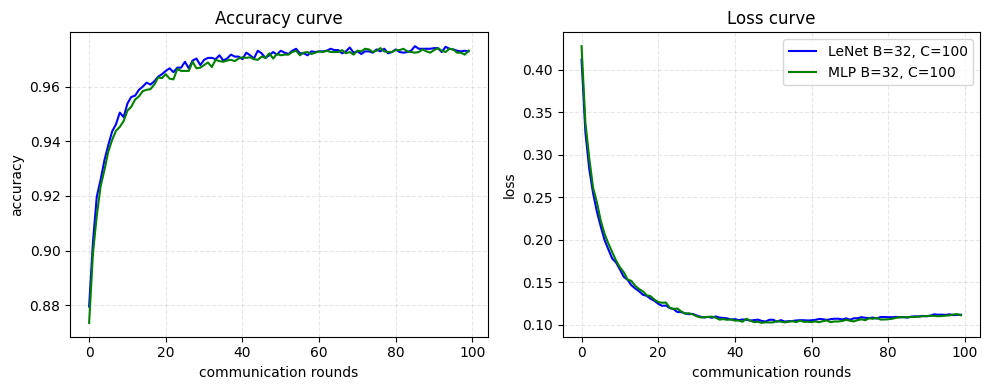

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
lets_plot(acc_lenet_plot, label='', title='', ylabel='', color='blue')
lets_plot(acc_mlp_plot, label='', title='Accuracy curve', ylabel='accuracy', color='green')
plt.subplot(1,2,2)
lets_plot(loss_lenet_plot, label='LeNet B=32, C=100', title='', ylabel='', color='blue')
lets_plot(loss_mlp_plot, label='MLP B=32, C=100', title='Loss curve', ylabel='loss', color='green')

## OTA no fading in $\mathbb R$
No fading: $h_i^t=1 \,\,\forall t$

In [ ]:
def create_rand_noise(in_list, mean, sd):
  """
  Args: create random Tensor with normally distributed elements with the
        same size of input tensor (noise)
    in_list: input list (average_weights)
  Returns: list of Tensor, with same dim of input list
  """
  out_list = in_list.copy()
  for i in range(len(out_list)):
    out_list[i] = tf.random.normal(shape=out_list[i].shape, mean=mean, stddev=sd, dtype=tf.float64)
  return out_list

In [ ]:
def training_model_real_AirComp_no_fading(comms_round, lr, loss, metrics, model_type, model, client_batched, test_batched, noise_mean, noise_sd):
  global_count = sum(len(list(clients_batched[client_name])) for client_name in list(clients_batched.keys()))*batch_size # n

  loss_history = [] # empty lists for plots
  acc_history = []

  for i in range(comms_round):
    # initialized weights of global model
    global_weights = model.get_weights()

    # initial list to collect local model weights after scaling
    scaled_local_weight_list = list()

    # randomize client data by keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    for client in client_names: # iterate through client training
      # tf.keras.backend.clear_session()
      local_model = build_model(shape=784, classes=10, model_type=model_type)
      client_optimizer = keras.optimizers.SGD(learning_rate = lr,
                                  weight_decay = lr/comms_round,
                                  momentum = 0.9)

      local_model.compile(loss=loss, optimizer=client_optimizer, metrics=metrics)

      # set local model weight to the weight of the global model
      local_model.set_weights(global_weights)

      # fit local model with client's data
      local_model.fit(clients_batched[client], epochs=1, verbose=0)

      # scale the model weights and add to list
      scal_factor = scaling_factor(clients_batched, client, global_count)
      scaled_weights = scale_weights(local_model.get_weights(), scal_factor)

      scaled_local_weight_list.append(scaled_weights)

      # clear session to free memory after each communication round
      tf.keras.backend.clear_session()
      # https://keras.io/2.15/api/utils/backend_utils/


    # get average over all local model, sum of scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #### AirComp: add (real) normal noise
    noise = create_rand_noise(average_weights, noise_mean, noise_sd)
    AirComp_average_weights = list()
    for comp in range(len(average_weights)):
      AirComp_average_weights.append(average_weights[comp] + noise[comp])
    ####

    # update global model
    model.set_weights(AirComp_average_weights)

    # test global model and print metrics
    catcren = tf.keras.losses.CategoricalCrossentropy()
    for(X_test_batch, y_test_batch) in test_batched:
      logits = model.predict(X_test_batch)
      global_loss = catcren(y_test_batch, logits)
      global_acc = sklearn.metrics.accuracy_score(tf.argmax(logits, axis=1), tf.argmax(y_test_batch, axis=1))
      print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(i, global_acc, global_loss))
      acc_history.append(global_acc)
      loss_history.append(global_loss)

  return acc_history, loss_history, model

In [ ]:
noise_sd = 0.01
air_acc_001, air_loss_001 = training_model_real_AirComp_no_fading(comms_round, learning_rate, loss,
                                                                  metrics, 'mlp', mlp_model,
                                                                  clients_batched, test_batched,
                                                                  noise_mean, noise_sd)

KeyboardInterrupt: 

Write loss and accuracy results into `.txt` files, where sigma is written in the file name as integer (e.g. sigma=0.01 became 1).

In [ ]:
write_results_to_txt_file('file_out_real_acc_ota_1', air_acc_001, out_path)
write_results_to_txt_file('file_out_real_loss_ota_1', air_loss_001, out_path)

In [ ]:
noise_sd = 0.02
air_acc_002, air_loss_002 = training_model_real_AirComp_no_fading(comms_round, learning_rate, loss,
                                                                  metrics, 'mlp', mlp_model,
                                                                  clients_batched, test_batched,
                                                                  noise_mean, noise_sd)

In [ ]:
write_results_to_txt_file('file_out_real_acc_ota_2', air_acc_002, out_path)
write_results_to_txt_file('file_out_real_loss_ota_2', air_loss_002, out_path)

In [ ]:
noise_sd = 0.03
air_acc_003, air_loss_003 = training_model_real_AirComp_no_fading(comms_round, learning_rate, loss,
                                                                  metrics, 'mlp', mlp_model,
                                                                  clients_batched, test_batched,
                                                                  noise_mean, noise_sd)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 0 | global_acc: 84.143% | global_loss: 0.5159580707550049
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
comm_round: 1 | global_acc: 88.333% | global_loss: 0.3888539671897888
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 2 | global_acc: 90.452% | global_loss: 0.33004701137542725
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 3 | global_acc: 90.738% | global_loss: 0.308698832988739
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 4 | global_acc: 91.214% | global_loss: 0.3007116913795471
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 5 | global_acc: 91.500% | global_loss: 0.30398645997047424
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 6 | global_acc: 92.119% | global_loss: 0.2708137333393097
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 7 | global_acc: 92.310% | global_loss: 0.2610447406768799
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 8 | global_acc: 91.548% | global_loss: 0.2861228585243225


In [ ]:
write_results_to_txt_file('file_out_real_acc_ota_3', air_acc_003, out_path)
write_results_to_txt_file('file_out_real_loss_ota_3', air_loss_003, out_path)

In [ ]:
noise_sd = 0.04
air_acc_004, air_loss_004 = training_model_real_AirComp_no_fading(comms_round, learning_rate, loss,
                                                                  metrics, 'mlp', mlp_model,
                                                                  clients_batched, test_batched,
                                                                  noise_mean, noise_sd)

In [ ]:
write_results_to_txt_file('file_out_real_acc_ota_4', air_acc_004, out_path)
write_results_to_txt_file('file_out_real_loss_ota_4', air_loss_004, out_path)

Comparing plots

In [ ]:
# read loss and accuracy lists from .txt files for comparing plots
acc_ota_001_plot = read_results_from_txt_file('file_out_real_acc_ota_1', out_path)
loss_ota_001_plot = read_results_from_txt_file('file_out_real_loss_ota_1', out_path)

acc_ota_002_plot = read_results_from_txt_file('file_out_real_acc_ota_2', out_path)
loss_ota_002_plot = read_results_from_txt_file('file_out_real_loss_ota_2', out_path)

acc_ota_003_plot = read_results_from_txt_file('file_out_real_acc_ota_3', out_path)
loss_ota_003_plot = read_results_from_txt_file('file_out_real_loss_ota_3', out_path)

#acc_ota_004_plot = read_results_from_txt_file('file_out_real_acc_ota_4', out_path)
#loss_ota_004_plot = read_results_from_txt_file('file_out_real_loss_ota_4', out_path)

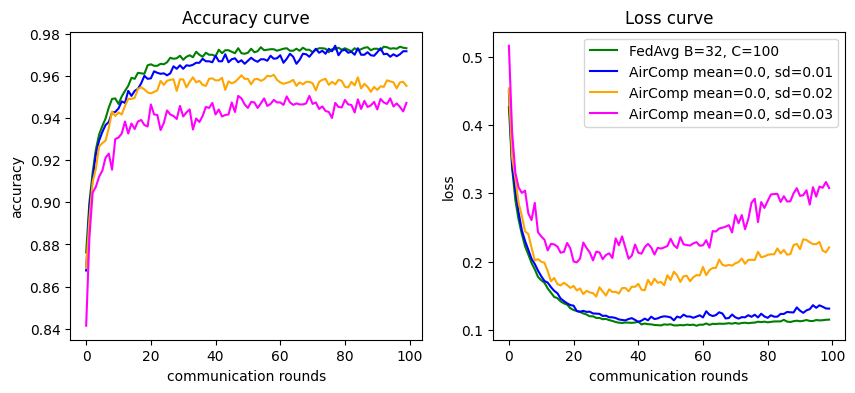

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1) # accuracy
lets_plot(acc_mlp_plot, label='', title='', ylabel='', color='green')
lets_plot(acc_ota_001_plot, label='', title='', ylabel='', color='blue')
lets_plot(acc_ota_002_plot, label='', title='', ylabel='', color='orange')
lets_plot(acc_ota_003_plot, label='', title='Accuracy curve', ylabel='accuracy', color='magenta')
#lets_plot(acc_ota_004_plot, label='', title='Accuracy curve', ylabel='accuracy', color='yellow')

plt.subplot(1,2,2) # loss
lets_plot(loss_mlp_plot, label='FedAvg B=32, C=100', title='', ylabel='', color='green')
lets_plot(loss_ota_001_plot, label='AirComp mean=0.0, sd=0.01', title='', ylabel='', color='blue')
lets_plot(loss_ota_002_plot, label='AirComp mean=0.0, sd=0.02', title='', ylabel='', color='orange')
lets_plot(loss_ota_003_plot, label='AirComp mean=0.0, sd=0.03', title='Loss curve', ylabel='loss', color='magenta')
#lets_plot(loss_ota_004_plot, label='AirComp mean=0.0, sd=0.04', title='Loss curve', ylabel='loss', color='yellow')

## Testing batch size


With values above
10 taking advantage of the speed-up of matrix-matrix products over matrix-vector products.

The impact of B is mostly computational,
larger B yield faster computation, but requires visiting
more examples in order to reach the same error,
since there are less updates per epoch.
https://arxiv.org/pdf/1206.5533

https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/

How to select Batch Size?
- Start with a Moderate Batch Size: Begin with a size like 32 or 64. This is generally a good starting point and provides a balance between stability and training speed.
- Increase Gradually: If you have the computational resources, gradually increase the batch size and observe if it improves performance.
- Use Batch Size as a Hyperparameter: Treat batch size as a hyperparameter to be tuned along with learning rates and other parameters.

In [ ]:
batch_size = 50

In [ ]:
clients_batched = dict()
for (client_name, data) in clients.items():
  clients_batched[client_name] = batch_data(data, batch_size)

test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
list(clients_batched['client_1'])[0][0].shape[0] # check batch size

50

In [ ]:
global_count = sum(len(list(clients_batched[client_name])) for client_name in list(clients_batched.keys()))*batch_size

In [ ]:
  for i in range(comms_round):
    # initialized weights of global model
    global_weights = mlp_model.get_weights()

    # initial list to collect local model weights after scaling
    scaled_local_weight_list = list()

    # randomize client data by keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    # iterate through client training
    for client in client_names:
      local_model = build_model(shape=784, classes=10)
      client_optimizer = keras.optimizers.SGD(learning_rate = learning_rate,
                                  weight_decay = learning_rate/comms_round,
                                  momentum = 0.9)

      local_model.compile(loss=loss, optimizer=client_optimizer, metrics=metrics)

      # set local model weight to the weight of the global model
      local_model.set_weights(global_weights)

      # fit local model with client's data
      local_model.fit(clients_batched[client], epochs=1, verbose=0)

      # scale the model weights and add to list
      scaling_factor_10 = scaling_factor(clients_batched, client, global_count)
      scaled_weights = scale_weights(local_model.get_weights(), scaling_factor_10)

      scaled_local_weight_list.append(scaled_weights)

      # clear session to free memory after each communication round
      tf.keras.backend.clear_session()
      # https://keras.io/2.15/api/utils/backend_utils/

    # get average over all local model, sum of scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    # update global model
    mlp_model.set_weights(average_weights)

    # test global model and print out metrics after each communications round i
    for(X_test, Y_test) in test_batched:
      global_acc, global_loss = test_model(X_test, Y_test, mlp_model, i)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 0 | global_acc: 97.000% | global_loss: 1.4984257221221924
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 1 | global_acc: 97.119% | global_loss: 1.4981484413146973
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 2 | global_acc: 97.095% | global_loss: 1.4978971481323242
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
comm_round: 3 | global_acc: 97.071% | global_loss: 1.497671127319336
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 4 | global_acc: 97.048% | global_loss: 1.497506856918335
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 5 | global_acc: 97.143% | global_loss: 1.4972349405288696
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 6 | global_acc: 97.143% | global_loss: 1.49708890914917
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
comm_round: 7 | global_acc: 97.119% | global_loss: 1.4969578981399536
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
comm_round: 8 | global_acc: 97.143% | global_loss: 1.4967719316482544
132/1

# Appendix


### Plots for Latex

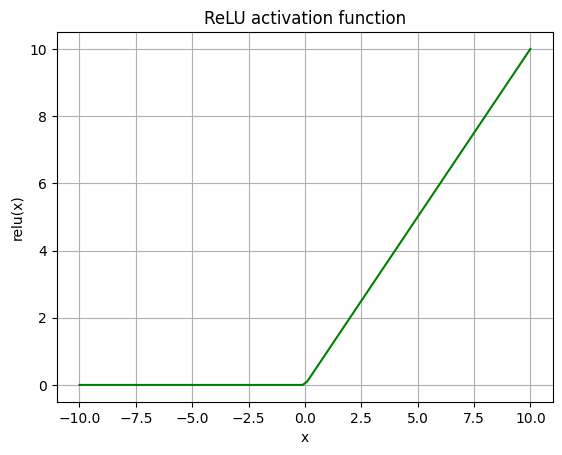

In [ ]:
# plot relu function
x = np.linspace(-10, 10, 100)
relu = np.maximum(0, x)

plt.plot(x, relu, color='green')
plt.xlabel('x')
plt.ylabel('relu(x)')
plt.title('ReLU activation function')
plt.grid(True)
plt.show()

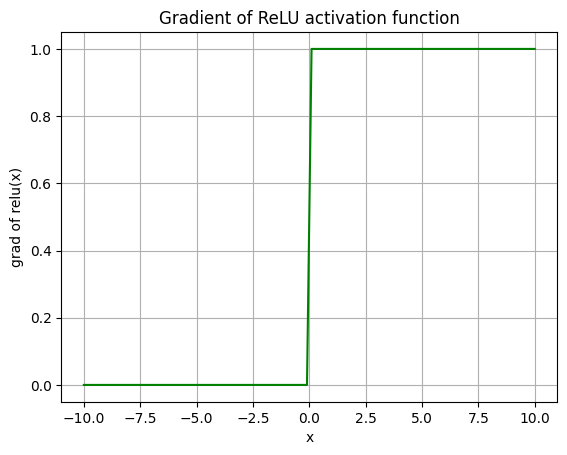

In [ ]:
# plot gradient of relu function
data = [1 if value>0 else 0 for value in x]
grad_relu = np.array(data, dtype=float)
plt.plot(x, grad_relu, color='green')
plt.xlabel('x')
plt.ylabel('grad of relu(x)')
plt.title('Gradient of ReLU activation function')
plt.grid(True)
plt.show()

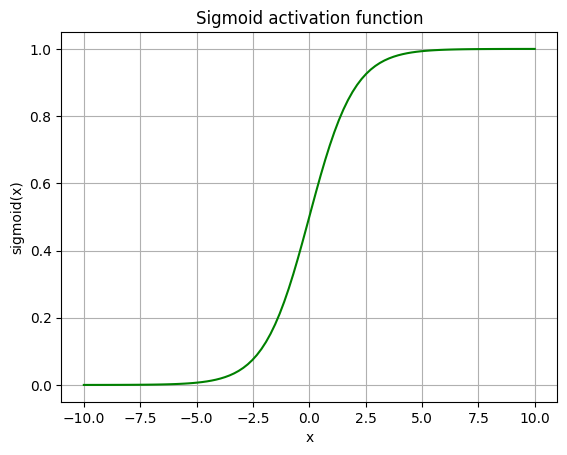

In [ ]:
# sigmoid function
x = np.linspace(-10, 10, 100)
sigm = 1 / (1 + np.exp(-x))

plt.plot(x, sigm, color='green')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid activation function')
plt.grid(True)
plt.show()

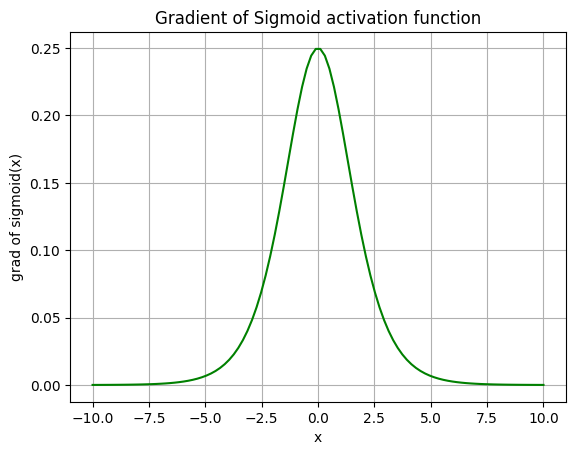

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def der_sigmoid(x):
  return sigmoid(x) * (1- sigmoid(x))

plt.plot(x, der_sigmoid(x), color='green')
plt.xlabel('x')
plt.ylabel('grad of sigmoid(x)')
plt.title('Gradient of Sigmoid activation function')
plt.grid(True)
plt.show()

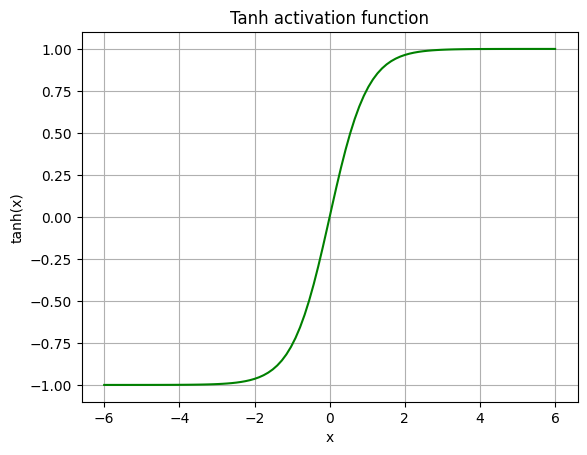

In [ ]:
x = np.linspace(-6, 6, 100)
tanh = (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

plt.plot(x, tanh, color='green')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Tanh activation function')
plt.grid(True)
plt.show()

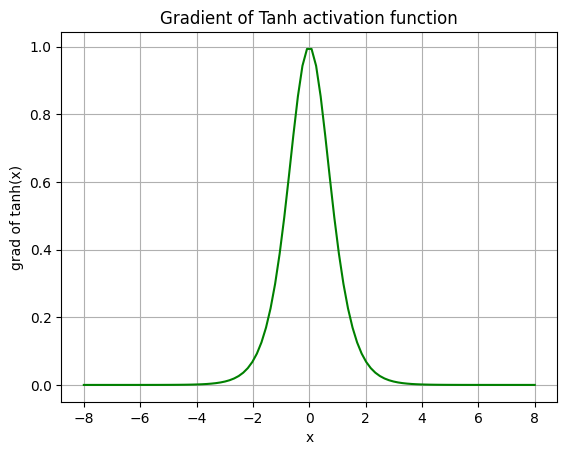

In [ ]:
def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def der_tanh(x):
  return 1 - tanh(x) * tanh(x)
x = np.linspace(-8, 8, 100)
dy_data = der_tanh(x)

plt.plot(x, dy_data, color='green')
plt.title('Gradient of Tanh activation function')
plt.xlabel('x')
plt.ylabel('grad of tanh(x)')
plt.grid()
plt.show()

## Sitography


*   https://github.com/arjun-majumdar/Federated_Learning/blob/main/Federated_Learning-MNIST_example.ipynb

*   https://github.com/AmineSahli1501/MNIST

* https://towardsdatascience.com/federated-learning-a-step-by-step-implementation-in-tensorflow-aac568283399

* https://github.com/Germoe/LeNet-300-100/blob/main/LeNet-300-100-LTH-Paper.ipynb
* https://arxiv.org/abs/1803.03635